<font face="Time New Roman" size=12 color=#A52A2A >
PHYS20762 Computational Physics
    <br>
    <font face="Time New Roman" size=7 color=black >
        <br>
        Monte Carlo Method
        <font face="Time New Roman" size=5 color=black >
    <br>
Pan Zhang
    <font face="Time New Roman" size=5 color=black >
    <br>
University of Manchester
    <br>
March 2022


<font face="Time New Roman" size=5 color=black >
1. Introduction

In the last project, we learn numerical integration based on summing up the continuous function by dividing it into a small rectangle just like Riemann Sum. 
The Monte Carlo method is a computational algorithm that provides the numerical solution that relies on randomness and random sampling. The random number can be set to follow certain distributions such as binomial distribution, Gaussian distribution, etc. Therefore, it can connect with many Physics topics such as simulating the microscopic movement of the particles, solving quantum mechanics wavefunctions, and simulating the solid-state diffusion.

In this project, we only focus on the simplest application of Monte Carlo Methods, simulating the process of the neutron in different materials and hence know the probability of neutron being scattered, absorbed, and reflected.

There are a few assumptions made here. We assume the proton is the thermal neutron which means we ignore its quantum effect.

In [184]:
#import library
import sys
import numpy as np
import matplotlib.pyplot as plt
from mpl_toolkits.mplot3d import Axes3D
from scipy import constants
from scipy.optimize import curve_fit
import pandas as pd
import time
import matplotlib as mpl
mpl.rc('figure', max_open_warning = 0)

%matplotlib notebook

First of all,let's define the most common used function in this project，'plot' and 'reshaper'. 

Plot function avoids us to repeat defining new subplot and forgetting state$$plt.show()$$.

In [185]:
def plot(
    data_array, title, x_label, y_label, z_label="", TWO_DIMENSION=True, cmap=False
):
    try:
        if TWO_DIMENSION:  # Two dimension plot
            fig = plt.figure(figsize=(6, 5))
            main_plot = fig.add_subplot(111)
            main_plot.set_title(title, fontsize="17")
            main_plot.set_xlabel(x_label, fontsize="15")
            main_plot.set_ylabel(y_label, fontsize="15")
            main_plot.scatter(data_array[:, 0], data_array[:, 1])
        else:
            fig = plt.figure(figsize=(6, 5))  # Three dimension plot
            main_plot = fig.add_subplot(projection="3d")
            main_plot.set_title(title, fontsize="17")
            if cmap:
                radius = -(
                    (
                        data_array[:, 0] ** 2
                        + data_array[:, 1] ** 2
                        + data_array[:, 2] ** 2
                    )
                    ** 0.5
                )
                main_plot.scatter(
                    data_array[:, 0],
                    data_array[:, 1],
                    data_array[:, 2],
                    cmap="Greens",
                    c=radius,
                )
            else:
                main_plot.scatter(
                    data_array[:, 0], data_array[:, 1], data_array[:, 2], color="red"
                )
            main_plot.set_xlabel(x_label)
            main_plot.set_ylabel(y_label)
            main_plot.set_zlabel(z_label)
        plt.show()
        return None
    except TypeError:
        print("Encounter Type error for some reason")
        sys.exit()
    except ValueError:
        print("encounter Value Error for some reason")
        sys.exit()
    except IndexError:
        print("Check the types of graph you want")
        sys.exit()


def plot_curve_fit(data_array, function, parameter, x_label, y_label, title):
    fig = plt.figure(figsize=(6, 5))  # plot the fitted curve
    main_plot = fig.add_subplot(111)
    main_plot.set_title(title, fontsize="17")
    main_plot.set_xlabel(x_label, fontsize="15")
    main_plot.set_ylabel(y_label, fontsize="15")

    x_array_fit = np.linspace(
        np.amin(data_array[:, 0]), np.amax(data_array[:, 0]), len(data_array[:, 0])
    )
    y_array_fit = function(x_array_fit, parameter)

    main_plot.errorbar(data_array[:, 0], data_array[:, 1], data_array[:, 2], fmt="x")
    main_plot.plot(x_array_fit, y_array_fit, color="black")
    plt.show()
    return None


def hist_plot(data_array, title, bins_number, x_label, y_label):
    fig = plt.figure(figsize=(6, 5))  # plot the histogram
    main_plot = fig.add_subplot(111)
    main_plot.set_title(title, fontsize="17")
    main_plot.set_xlabel(x_label, fontsize="15")
    main_plot.set_ylabel(y_label, fontsize="15")
    main_plot.hist(data_array, bins=bins_number, edgecolor="black")
    plt.show()
    return None


def plot_3D_path(
    data_array, x_label, y_label, z_label, title, legends, multipath=False
):
    if multipath == False:  # plot the single path
        fig = plt.figure(figsize=(6, 5))
        main_plot = fig.add_subplot(projection="3d")
        main_plot.set_title(title)
        main_plot.set_xlabel(x_label)
        main_plot.set_ylabel(y_label)
        main_plot.set_zlabel(z_label)
        main_plot.plot(data_array[:, 0], data_array[:, 1], data_array[:, 2])
        main_plot.legend(legends)
        plt.show()
    elif multipath == True:  # plot multipath
        fig = plt.figure(figsize=(6, 5))
        main_plot = fig.add_subplot(projection="3d")
        main_plot.set_title(title)
        main_plot.set_xlabel(x_label)
        main_plot.set_ylabel(y_label)
        main_plot.set_zlabel(z_label)
        main_plot.plot(
            data_array[0][:, 0],
            data_array[0][:, 1],
            data_array[0][:, 2],
            label=legends[0],
        )
        main_plot.plot(
            data_array[1][:, 0],
            data_array[1][:, 1],
            data_array[1][:, 2],
            label=legends[1],
        )
        main_plot.plot(
            data_array[2][:, 0],
            data_array[2][:, 1],
            data_array[2][:, 2],
            label=legends[2],
        )
        main_plot.legend()
        plt.show()
    return None


In this program, we encounter many problems about the error calculation and curve fitting. To be convinient, reshaper function is created to convert the array from $$[d × n]$$ to $$[n × d]$$.

n is the group of data. d is the dimension such as x, y, z coordinate.

In [186]:
def reshaper(data_array):
    """
    reshape the data array

    Parameters
    ----------
    x_value : array
        x axis value
    y_value : array
        y axis value
    y_uncertainty : array
        y uncertainty

    Returns
    -------
    data_array : a [n * 3] array
        x, y, y uncertainty data in an array

    """
    try:
        x_array, y_array, z_array = data_array
        x_reshape = x_array.reshape(len(x_array), 1)
        y_reshape = y_array.reshape(len(y_array), 1)
        z_reshape = z_array.reshape(len(z_array), 1)
        new_data_array = np.hstack((x_reshape, y_reshape, z_reshape))
        return new_data_array
    except ValueError:
        x_array, y_array = data_array
        x_reshape = x_array.reshape(len(x_array), 1)
        y_reshape = y_array.reshape(len(y_array), 1)
        new_data_array = np.hstack((x_reshape, y_reshape))
        return new_data_array


<font face="Time New Roman" size=5 color=black >
2. random number generators

The most important code in this project is $np.random$. This function can generate the random points that follows certain distribution such as uniform distribution or the normal distribution. Let's call this function to test whether it works.

In [187]:
def random_number_generator(min_int, max_int, number_of_random_number, distribution):
    try:
        x_array = np.linspace(min_int, max_int, number_of_random_number)
        if distribution == "uniform":
            random_number_generator = np.random.uniform(
                min_int, max_int, number_of_random_number
            )
        if distribution == "normal":
            random_number_generator = np.random.normal(
                min_int, max_int, number_of_random_number
            )
        return x_array, random_number_generator
    except AttributeError:
        print("The distribution name is wrong.")
    except ValueError:
        print("Value Error for some reason")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


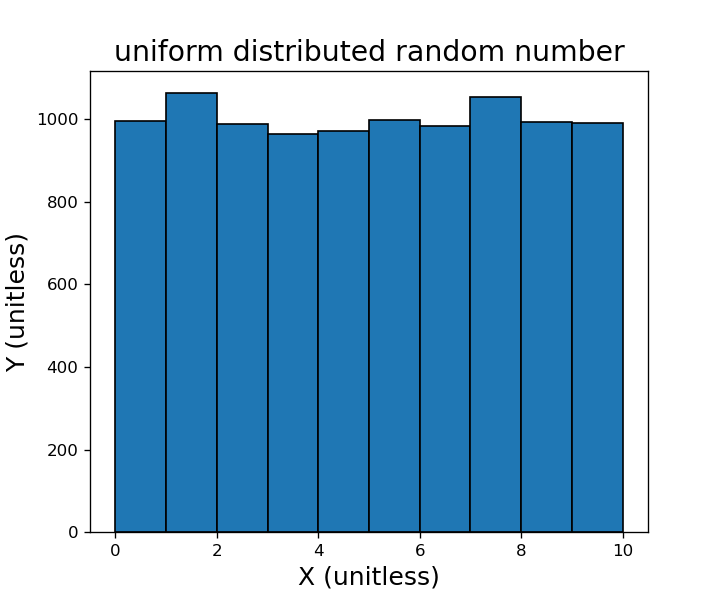

In [188]:
x_array, get_random_number = random_number_generator(0, 10, 10000, "uniform")

X_ARRAY = x_array
Y_ARRAY = get_random_number
data_array = reshaper([X_ARRAY, Y_ARRAY])

######
"plot"
######
PLOT_NAME = "uniform distributed random number"
plot(
    data_array,
    PLOT_NAME,
    "X (unitless)",
    "Y (unitless)",
    "Test uniform distributed random number",
)

hist_plot(get_random_number, "uniform distributed random number", 10, "X (unitless)", "Y (unitless)")


From the histogram and 2D graph, we can see that the random number is uniformly distributed because the random number mapping the 2D graph with the same density and the bins of the histogram has the same probabilities.

Now, let's take a look at the normal distributed random number.

<IPython.core.display.Javascript object>


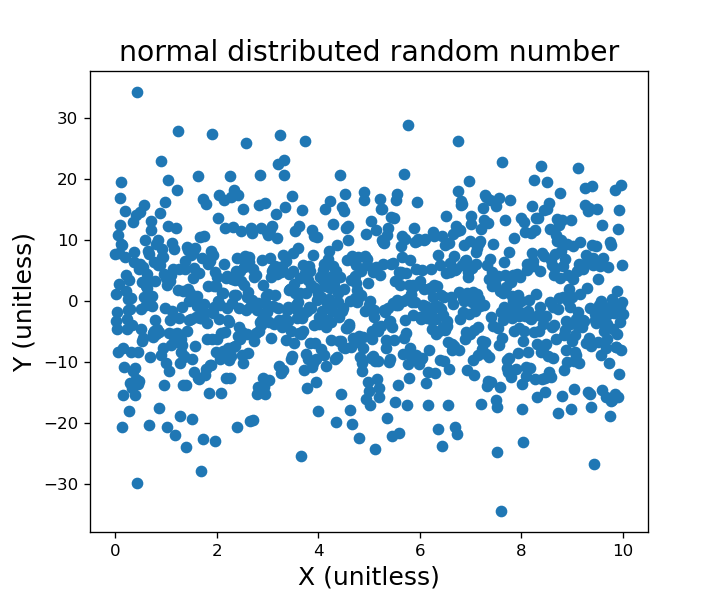

<IPython.core.display.Javascript object>


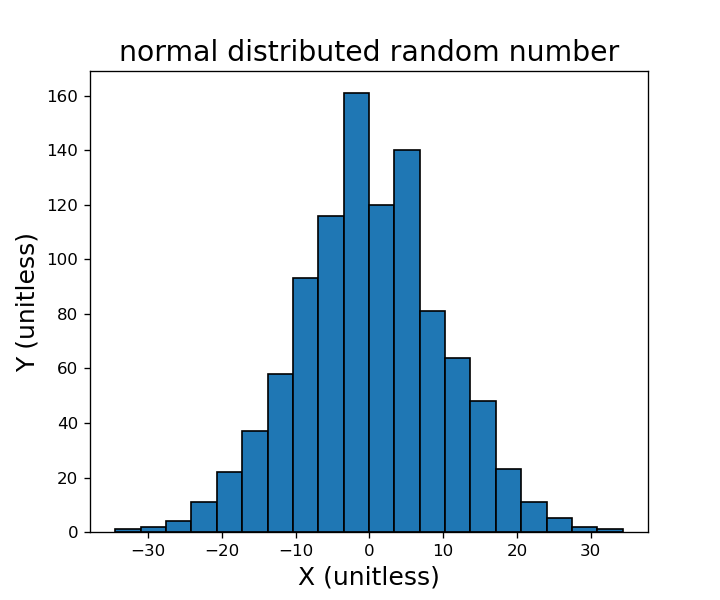

In [189]:
x_array, get_random_number = random_number_generator(0, 10, 1000, "normal")

X_ARRAY = x_array
Y_ARRAY = get_random_number
data_array = reshaper([X_ARRAY, Y_ARRAY])

######
"plot"
######
PLOT_NAME = "normal distributed random number"
X_LABEL = "X (unitless)"
Y_LABEL = "Y (unitless)"
plot(data_array, PLOT_NAME, X_LABEL, Y_LABEL)

hist_plot(get_random_number, "normal distributed random number", 20, "X (unitless)", "Y (unitless)")


Normal distribution explains the movement and the behavior of most of the objects in nature. However, the samples in nature are large. Therefore, in the simulated graph above, although the random number seems to follow the normal distribution, the histogram shape is not perfect. To have a perfectly normal distributed shape, we need to increase the random number point. Let's have one hundred thousand points.

In [190]:
x_array, get_random_number = random_number_generator(0, 10, 100000, "normal")

X_ARRAY = x_array
Y_ARRAY = get_random_number
data_array = reshaper([X_ARRAY, Y_ARRAY])

######
"plot"
######
PLOT_NAME = "normal distributed random number"
X_LABEL = "X (unitless)"
Y_LABEL = "Y (unitless)"
plot(data_array, PLOT_NAME, X_LABEL, Y_LABEL)

hist_plot(get_random_number, "normal distributed random number", 50, "X (unitless)", "Y (unitless)")


<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

The histogram of normal distribution looks much better than the last one! We will prove the variance and central limit theorem in the next part.

Now, you may ask how to generate the random number or what is the mechanism behind the NumPy.random this function? This leads us to the pseudo-random number generator. LCG sequence repeats over a full period m as long as: $$X_{n+1} = (aX_{n}+c)modm$$ where $0<m, 0\leq a < m$, $0 < c < m$, $0 \leq x_{0} < m$. With this parameter, we can generate the random number using the equation $$s_{n} = \frac{X_{n}}{m}$$

The pseudo-random number generator returns a sequence of random numbers with a given random number(seed). From the statistical perspective, this sequence of numbers is purely random. However, this sequence of random numbers is not random but correlates with each other. We can show this correlation by doing the spectral test.

In [191]:
# some parameters
X = 123456789 
A = pow(2, 16) + 3
C = 0
M = pow(2, 31)

In [192]:
def LCG(dimension, number_data_array, compiler=2, x=X, a=A, c=C, m=M):
    if compiler == 2:  # different compiler, here we use the default compiler
        pass
    elif compiler == 1:
        a = 1664525
        c = 1013904224
    elif compiler == 3:
        a = 1103514245
        c = 12345
    elif compiler == 4:
        a = 134775813
        c = 1
    elif compiler == 5:
        a = 214013
        c = 2531011
    else:
        print("out of choice, system out")
        sys.exit()
    r = np.zeros([dimension, number_data_array])

    for l in range(0, number_data_array):
        for k in range(0, dimension):
            x = np.mod(a * x + c, m)
            r[k, l] = x / m
    return r


<IPython.core.display.Javascript object>


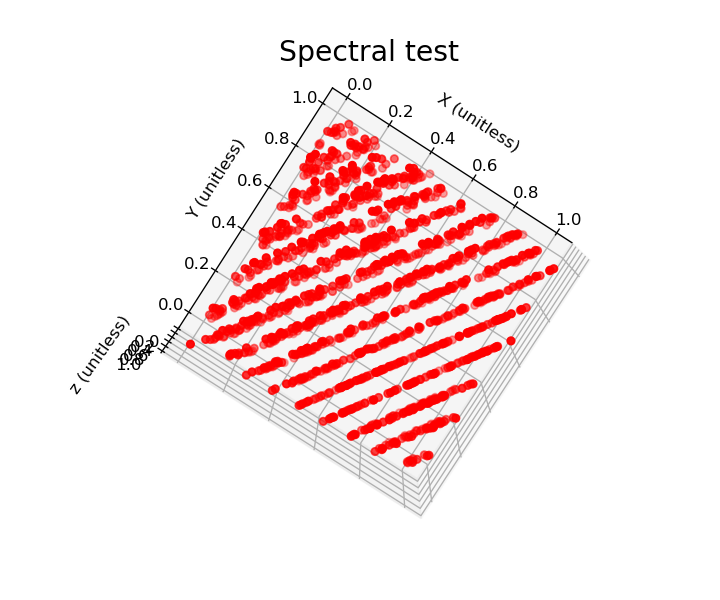

In [231]:
three_dimension_random_number = LCG(3, 1500)
data_array = reshaper(three_dimension_random_number)
######
"plot"
######
PLOT_NAME = "Spectral test"
X_LABEL = "X (unitless)"
Y_LABEL = "Y (unitless)"
Z_LABEL = "z (unitless)"

plot(data_array, PLOT_NAME, X_LABEL, Y_LABEL, Z_LABEL, TWO_DIMENSION=False)


As the above figure shows, the value in x axis is correlated with value in y axis. To solve this problem, we could use LCG to generate 'random number' first, then suffle them again to get a more random number.

We used numpy library to generate normal distributed random number and here we can use try to generate the random number with the formula:$$g = \frac{\sum_{i=1}^{n} u_{i}-\frac{n}{2}}{\sqrt{\frac{n}{12}}}$$

u is the random number that follows the uniform distribution. n is the number of uniformly distributed random samples for each normal distributed random number. For example, we can take n as 6 which means we sum up 6 uniformly distributed random numbers.

The question is that how many random number points should I take for each normal distributed random point? The answer is we need 12.

In [198]:
def normal(boundary_min, boundary_max, random_number_point):
    normal_array = np.zeros(random_number_point)
    x_array = np.linspace(boundary_min, boundary_max, random_number_point)
    for i in range(random_number_point):
        u = np.random.uniform(boundary_min, boundary_max, 30)
        g = (np.sum(u) - 30 / 2) / (30 / 12) ** 0.5
        normal_array[i] = g
    return normal_array, x_array


<IPython.core.display.Javascript object>


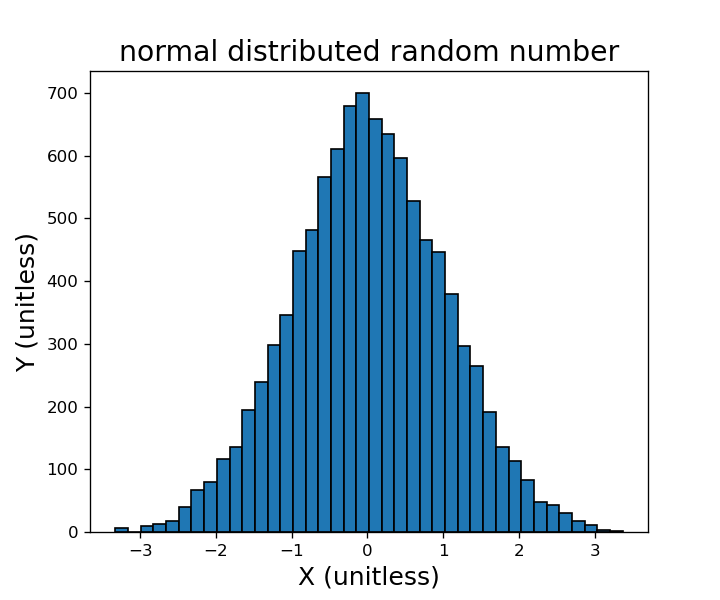

<IPython.core.display.Javascript object>


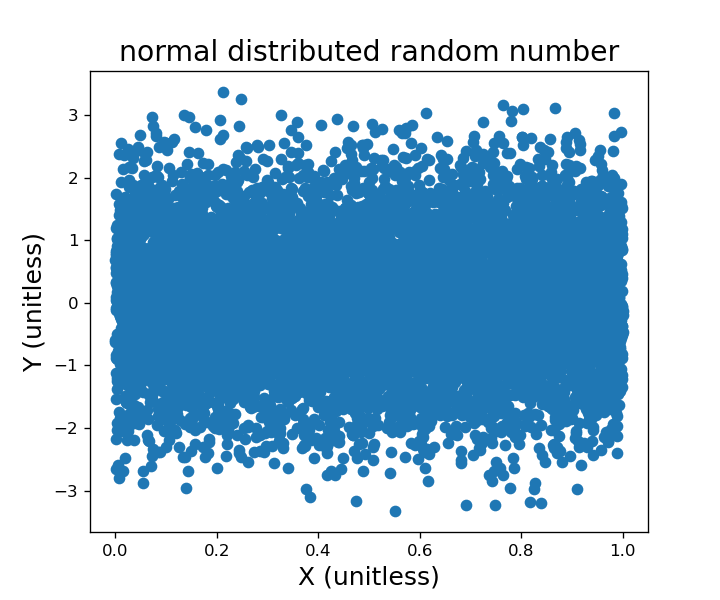

In [195]:

normal_random_array, x_array = normal(0, 1, 10000)
data_array = reshaper([x_array, normal_random_array])
################
"plot hist"
#################
X_LABEL = "X (unitless)"
Y_LABEL = "Y (unitless)"

PLOT_NAME = "normal distributed random number"
hist_plot(normal_random_array, PLOT_NAME, 40, X_LABEL, Y_LABEL)


######
"plot"
######
PLOT_NAME = "normal distributed random number"
plot(data_array, PLOT_NAME, X_LABEL, Y_LABEL)


<font face="Time New Roman" size=5 color=black >
3. neutron movement in different materials

<font face="Time New Roman" size=4 color=black >
3.1 simulation without consider scattering

Now, we are at the most important part of our project, simulating the movement of the neutron in different materials. Just like the last project, we will do some crazy things such as simulate the neutron in the nucleus bump in the last section! 

Imaging that, we have a neutron move in different target materials that have different atomic sizes. The probability of the neutron going through, being scattered, and captured by this material atom is hence different. This can be described by the macroscopic cross-section which is defined as: $$\Sigma = n\sigma$$

$\Sigma$ is the total macroscopic cross sectiona, $\sigma$ is the microscopic cross section and $n$ is the number density of the material $n = \frac{\rho N_{A}}{M}$ where $\rho$ is the mass density of the target material, $ N_{A}$ is the Avogadro number and M is the molar mass.

After neutrons travel in the material for a while, some of them are captured or absorbed by the material and hence the intensity of this bunch of neutrons is decreased. The rate of absorption per unit thickness is defined to be $$ R = -\frac{dI}{dx} = n \sigma I$$ where I is the intensity of the neutron which is able to be rewritten as $\frac{N_{rest}}{N_{initial}}$

Solving this equation, we get the intensity variation with thickness to be a exponential decay function:
$$I = I_{0}e^{-n\sigma x}$$

We define the mean free path to be the inverse of the macroscopic cross section $$\lambda = \frac{1}{n\sigma}$$ Therefore, the intensity of the neutron is $$I = I_{0}e^{- \frac{x}{\lambda}}$$

In the next few cells, we implement above equations.

In [199]:
# define exponential function
def exponential(boundary_min, boundary_max, number_of_random_int, mean_free_path):
    random_numebr_uniform = np.random.uniform(
        boundary_min, boundary_max, number_of_random_int
    )
    exponential_array = -mean_free_path * np.log(random_numebr_uniform)
    return exponential_array, random_numebr_uniform


# define linear function
def linear_function(x, parameter):
    m, b = parameter
    return m * x + b


Now, we create our dictionary to store the information about the three types of the slab that we use in this project. The dictionary is a powerful tool to store the labeled data.
We also have the information about tungsten carbide[1] which is for simulating the movement of the neutron in the nuclear bump shield before the chain reaction happens.

In [200]:
water = {
    "absorption": [0.6652 * 10 ** -24, "cm^2"], # absorption X-section
    "scattering": [103.0 * 10 ** -24, "cm^2"], # scattering X-section
    "density": [1.00, "g/cm^3"],
    "molar mass": [18.01528, "g/mol"],
}

lead = {
    "absorption": [0.158 * 10 ** -24, "cm^2"],
    "scattering": [11.221 * 10 ** -24, "cm^2"],
    "density": [11.35, "g/cm^3"],
    "molar mass": [207.2, "g/mol"],
}
graphite = {
    "absorption": [0.0045 * 10 ** -24, "cm^2"],
    "scattering": [4.74 * 10 ** -24, "cm^2"],
    "density": [1.67, "g/cm^3"],
    "molar mass": [12.011, "g/mol"],
}

tungsten_carbide = {
    "absorption": [(1.63 + 0.0035) * 10 ** -24, "cm^2"],
    "scattering": [(7.35 + 5.551) * 10 ** -24, "cm^2"],  # elastic collision(scattering)
    "density": [15.6, "g/cm^3"],
    "molar mass": [195.86, "g/mol"],
}


To visualize the data stored in the dictionary, we use pandas framework.

In [201]:
def create_table(dictionary, title):
    try:
        tabel = pd.DataFrame(data=dictionary) # create table
        index = tabel.index
        index.name = title
    except ValueError:
        tabel = pd.DataFrame(data=dictionary, index=[0])#create table for single row.
        index = tabel.index
        index.name = title
    return tabel


In [202]:
create_table(water, 'water slab')

absorption scattering density molar mass
water slab                                         
0           6.652e-25   1.03e-22       1    18.0153
1                cm^2       cm^2  g/cm^3      g/mol

In [203]:
create_table(lead, 'lead slab')

absorption  scattering density molar mass
lead slab                                          
0           1.58e-25  1.1221e-23   11.35      207.2
1               cm^2        cm^2  g/cm^3      g/mol

In [204]:
create_table(graphite, 'graphite slab')

absorption scattering density molar mass
graphite slab                                         
0                4.5e-27   4.74e-24    1.67     12.011
1                   cm^2       cm^2  g/cm^3      g/mol

In [205]:
# function return the calcualted macroscopic crossection and mean free path from the material given
def calculate_mean_free_path(material):
    try:
        #call constants
        avogadro_number = constants.Avogadro
        absorption = material["absorption"][0]
        scattering = material["scattering"][0]
        density = material["density"][0]
        molar_mass = material["molar mass"][0]
        #calculate the mean free path, microscopic cross section
        number_of_molecules = density * avogadro_number / molar_mass
        macroscopic_absorption_x_section = number_of_molecules * absorption #macroscopic cross section =  n * microscopic 
                                                                            #cross section
        mean_free_path_absorption = 1 / macroscopic_absorption_x_section
        macroscopic_scattering_x_section = number_of_molecules * scattering

        return mean_free_path_absorption, macroscopic_scattering_x_section
    except NameError:
        print("we don't have the information about the material input")
        return 0


We now want to investigate the random number that follows the exponential distribution. To convert the exponential function, we take the logarithm of the exponential function. 

We want to do a quick simulation here to test the reliability of exponentially distributed random numbers and the curve fitting which is important in the latter section.

We assume there is no scattering between neutron and water and hence the characteristic attenuation length for water is about 45cm.

The intensity of the neutron in certain material follows the exponential distribution:$$I(x) = I_{0} e^{-n\sigma x} =  I_{0} e^{-\frac{x}{\lambda}}$$
If we take a ln in each side, and plot it in a 2D graph. We should expect to see a linear function with negative inverse mean free path to be the slope of the function $$\lambda = - \frac{1}{slope}$$; and if the intensity function is not standarised by dividing the whole function by $I_{0}$ we expect to see a y intercept. This y intercept is useless and we ignore it.

In [206]:
water_mean_free_path,get_water_microscopic_scattering = calculate_mean_free_path(water)
print('The mean free path of water is:', water_mean_free_path, 'The scattering cross section of water is:', get_water_microscopic_scattering)

The mean free path of water is: 44.97155178303617 The scattering cross section of water is: 3.4430799758871355


In [207]:
def log_exponential(data_array):
    data_array = data_filter(data_array)
    # convert the exponential to linear
    log_y = np.log(data_array[:, 1])
    log_error = data_array[:, 2] / data_array[:, 1]
    log_data_array = reshaper([data_array[:, 0], log_y, log_error])
    # now the y values are all -x/lambda
    return log_data_array


Before we do the curve fitting, we need to get rid of the inappropriate data such as -inf and nan. We need also to get rid of the outlier. The simplest way is to get rid of the data that has the z score larger than the threshold.
The way to calculate the z score is:$$z = \frac{x_{i}-\mu}{\sigma}$$
$\mu$ is the mean of the sample and $\sigma$ is the standard deviation of the sample. Normally, the z score threshold is set as: $$z_{threshold} = 3$$

These two methods can handle all the unreasonable data in this report.

In [208]:
def detect_outlier(data_array):
    """


    Parameters
    ----------
    data_array : numpy array
        The file data removed nan

    Returns
    -------
    detected_outlier_data : numpy array
        An array convert all outlier into zero

    """
    detected_outlier_data = np.array([])
    thres_z_value = 3
    mean = np.mean(data_array)
    stdv = np.std(data_array)
    for data in data_array:
        z_score = (data - mean) / stdv
        if np.abs(z_score) > thres_z_value:
            data = 0
        detected_outlier_data = np.append(detected_outlier_data, data)
    return detected_outlier_data


def data_filter(file_data):
    """


    Parameters
    ----------
    file_data : numpy array
        The original data in the file.

    Returns
    -------
    filtered_data : numpy array
        filtered data is the data removed outlier, nan, and
        they are continuous.

    """
    #remove nan
    filtered_data = np.zeros((0, 3))
    filt_nan = np.isnan(file_data).any(axis=1)
    no_nan_array = ~filt_nan
    no_nan_array = file_data[no_nan_array, :]
    #remove outlier
    data_removed_outlier_one = detect_outlier(no_nan_array[:, 0])
    data_removed_outlier_two = detect_outlier(no_nan_array[:, 1])
    data_removed_outlier_three = detect_outlier(no_nan_array[:, 2])

    temp = np.array(
        [data_removed_outlier_one, data_removed_outlier_two, data_removed_outlier_three]
    )
    temp = np.transpose(temp)
    
    for entry in temp:
        if not entry[1] == 0:
            filtered_data = np.vstack((filtered_data, entry))
    return filtered_data


To read the information of exponentially distributed data, we can use a histogram as before. The value of each bin is a random number within the bin edge. This means that a smaller bin edge will provide a more exponential distributed curve if we plot the bin value against the bin edge. The curve fits better if we take more bins.
Let's create a function to generate an exponential distributed random number and measure the exponential distribution range by counting the random number with a histogram.

In [236]:
def information_histogram(material, groups_of_measurement, sample_size, bins_size):
    # get the simulation data in the form array([group1], [group2])
    # group1 = np.array([[],[]],
    # [[],[]]
    # )
    histogram_data = []

    fig = plt.figure(figsize=(8, 6))
    main_plot = fig.add_subplot(111)
    main_plot.set_title("Simulate decay of neutron in water", fontsize="17")
    main_plot.set_xlabel('displacement (cm)')
    main_plot.set_ylabel('numbaer of neutron')
    mean_free_path, _ = calculate_mean_free_path(material)
    for i in range(groups_of_measurement):
        exponential_array, random_number = exponential(
            0, 1, sample_size, mean_free_path
        )
        get_number_particles_in_each_bin, get_bins_edge = np.histogram(
            exponential_array, bins_size
        )

        main_plot.hist(exponential_array, bins=bins_size)
        get_bins_edge = np.delete(get_bins_edge, -1)
        temp = reshaper([get_bins_edge, get_number_particles_in_each_bin])
        histogram_data.append(temp)
    # plot show
    plt.show()
    return histogram_data


We can use the below uncertainty_calculator to get the standard deviation of each bin. To get the statistical error, we repeat the above calling by several times. We do it ten times here.

In [237]:
def uncertainty_calculator(data_list):
    groups_of_measurement = len(data_list)
    groups_of_sample = len(data_list[0])

    mean = []
    standard_deviation = []
    mean_x = []

    y = np.zeros((groups_of_sample, 0))
    x = np.zeros((groups_of_sample, 0))
    for i in range(
        groups_of_measurement
    ):  # take more groups of measurement in order to have the statistical error
        temp_x = data_list[i][:, 0]
        temp_y = data_list[i][:, 1]
        temp_x = temp_x.reshape(groups_of_sample, 1)
        temp_y = temp_y.reshape(groups_of_sample, 1)
        y = np.hstack((y, temp_y))
        x = np.hstack((x, temp_x))
    # get rid of unappropriate value:
    y_std = np.std(y, axis=1)
    x_std = np.std(x, axis=1)
    x_mean = np.mean(x, axis=1)
    y_mean = np.mean(y, axis=1)
    return x_mean, y_mean, x_std, y_std


In [238]:

# We now want to test the exponential function by fitting it
# We need to 1. get the
def fitting_curve(data_array, degree_of_freedom):
    parameter, parameter_uncertainty = np.polyfit(
        data_array[:, 0], data_array[:, 1], degree_of_freedom, cov=True
    )
    return parameter, parameter_uncertainty


We call the function to generate an exponential distributed random number.

<IPython.core.display.Javascript object>


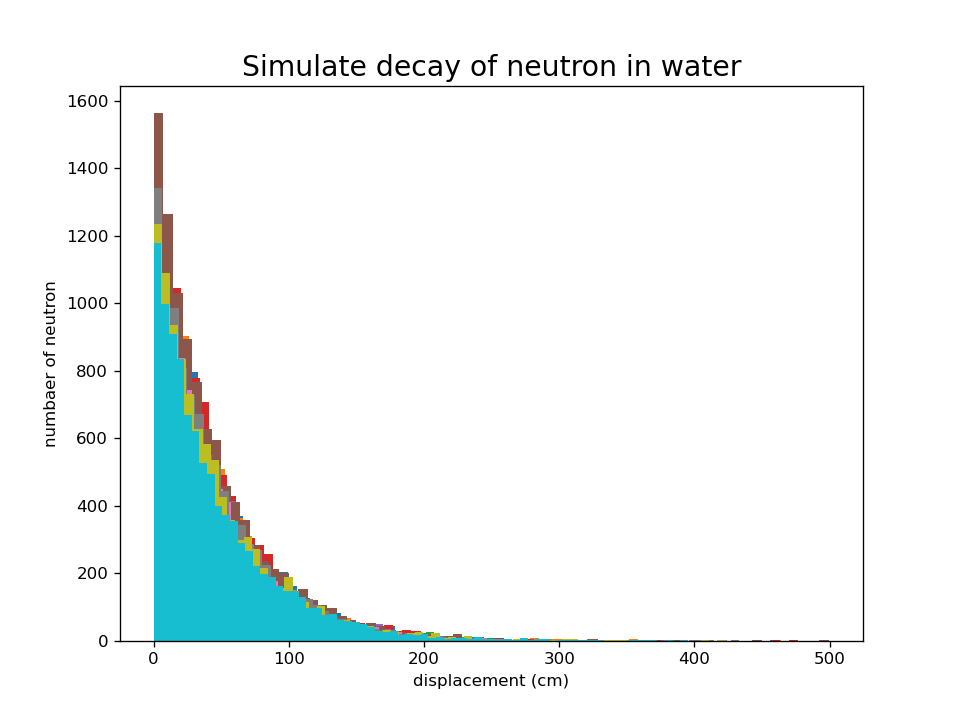

<IPython.core.display.Javascript object>

In [239]:
# prepare fitting data
get_information_histogram = information_histogram(water, 10, 10000, 70)
data_array = uncertainty_calculator(get_information_histogram)
data_array = reshaper([data_array[0], data_array[1], data_array[3]])
data_array = log_exponential(data_array)
parameter, parameter_uncertainty = fitting_curve(data_array, 1)
##########################
"plot"
##########################
X_LABEL = "displacement(m)"
Y_LABEL = "$log(I) \\frac{W}{m^{2}}$"
TITLE = "fit the logrithmic of exponential function water"
plot_curve_fit(data_array, linear_function, parameter, X_LABEL, Y_LABEL, TITLE)


Noting that the parameter_uncertainty gives us the variance of the parameter, we need to take the root of this value to get its standard deviation.

In [240]:
slope = parameter[0]
y_intercept = parameter[1]
mean_free_path = -1 / slope
mean_free_path_error = (
    -np.sqrt(np.diag(parameter_uncertainty))[0] / slope * mean_free_path
)
simulate_neutron_no_absorption = {
    "mean free path of neutron in water with no scattering": "{0:.1f}±{1:.1f}cm".format(
        mean_free_path, mean_free_path_error
    )
}
create_table(simulate_neutron_no_absorption, "simulation result")


mean free path of neutron in water with no scattering
simulation result                                                      
0                                                         47.7±1.0cm

<font face="Time New Roman" size=4 color=black >
3.2 Neutron movement with scattering

The random walk of the neutron in real life is three-dimensional. The probability of neutron going in each direction is the same so that its direction is isotropic. We can convert the uniform distribution in cartesian coordinate into spherical coordinate to achieve this. The number of the neutron in the slab follows the exponential distribution, so that the radius of the spherical distribution, R, is generated by calling the exponential function above.

In [241]:
def generate_isotropic_unit_vector(number_of_random_int):
    boundary_condition_phi = np.pi * 2
    boundary_condition_theta = np.pi
    random_phi = np.random.uniform(0, boundary_condition_phi, number_of_random_int)
    # to elimiate the concentrate point at south and north pole
    random_number = np.random.uniform(0, 1, number_of_random_int)
    random_theta = np.arccos(1 - 2 * random_number)
    #coordinate
    raondom_x = np.sin(random_theta) * np.cos(random_phi)
    random_y = np.sin(random_theta) * np.sin(random_phi)
    random_z = np.cos(random_theta)
    unit_vector = reshaper([raondom_x, random_y, random_z])
    return unit_vector


def generate_spherical_distribution(
    boundary_min, boundary_max, number_of_random_int, mean_free_path
):
    unit_vector_array = generate_isotropic_unit_vector(number_of_random_int) # call unit vector
    radius_array, random_number = exponential(
        boundary_min, boundary_max, number_of_random_int, mean_free_path
    ) # call radius
    vector_radius_array = np.zeros((0, 3))
    for index, value in enumerate(radius_array):
        temp = value * unit_vector_array[index]
        vector_radius_array = np.vstack((vector_radius_array, temp))
    # return random number u. It is used for random_path of scattering and absorption.
    return vector_radius_array, random_number


If the unit vector is perfecly uniformly distributed on the sphere, we should not see some point concentrate on the north pole or south pole. To resolve this problem, instead let $$\theta = u_{random},$$ we say $$\theta = cos^{-1}(1 - 2*u_{random})$$

It works pretty well as you can see it below.

<IPython.core.display.Javascript object>


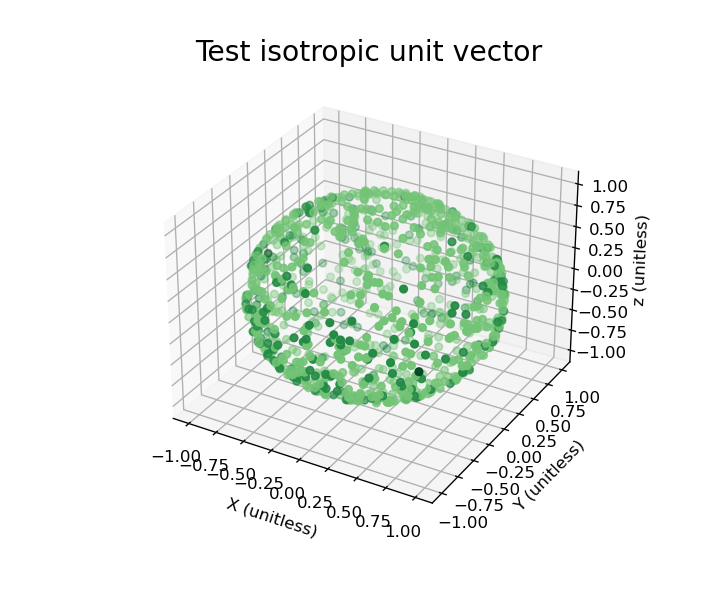

In [242]:
get_generate_isotropic_unit_vector = generate_isotropic_unit_vector(1000)

######
"plot"
######
PLOT_NAME = "Test isotropic unit vector"
X_LABEL = "X (unitless)"
Y_LABEL = "Y (unitless)"
Z_LABEL = "z (unitless)"
plot(
    get_generate_isotropic_unit_vector,
    PLOT_NAME,
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    TWO_DIMENSION=False,
    cmap=True,
)

<IPython.core.display.Javascript object>


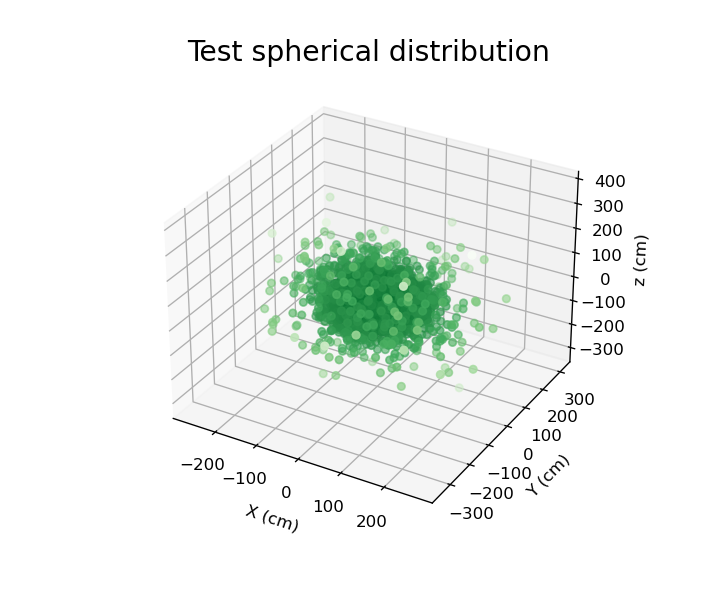

In [243]:
get_spherical_distribution, _ = generate_spherical_distribution(
    0, 1, 10000, water_mean_free_path
)  # simulate the free path of the neutron

######
"plot"
######
PLOT_NAME = "Test spherical distribution"
X_LABEL = "X (cm)"
Y_LABEL = "Y (cm)"
Z_LABEL = "z (cm)"
plot(
    get_spherical_distribution,
    PLOT_NAME,
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    TWO_DIMENSION=False,
    cmap=True,
)


The function in the next cell is the most important one in our project. It simulates the random walk of neutrons in different materials and decides the ending of the neutron based on the macroscopic cross-section of the materials.

The total macroscopic cross section of the material is the summation of all macroscopic cross section:
$$\Sigma_{total} = \sum_{i}^{i = n} \Sigma_{absorb_i}+\Sigma_{scatter_i}$$
n is the number of different types of material.

The total mean free path is hence equal to the inverse of whole macroscopic cross section.$$\lambda = \frac{1}{\Sigma_{total}}$$

Recall that we used a uniformly distributed random number to generate each random path of neutron. Hence, we can compare the uniformly distributed random number,$$u$$, with the probability being scattered $$p_{s} = \frac{\Sigma_{s}}{\Sigma_{a}+{\Sigma_{s}}}$$ and being absorbed $$p_{a} = \frac{\Sigma_{a}}{\Sigma_{a}+{\Sigma_{s}}}$$ to decide whether the neutron should take more random walk. (If u is less than the $p_{a}$, then absorption happens)

If a neutron is not absorbed by the material and left the boundary of the shield, depending on the position of the neutron, we say the neutron is transmitted or is reflected.

In [244]:

# This is the unoptimized random path function. It can provide both the ending of the neutron in different material
# and the path of neutron.
# We use this function to handle with the case where the number of neutron is approximately one hundred.
def random_path(material, thickness_of_slab, number_of_neutron):

    # information
    get_absorption_mean_free_path, get_scattering = calculate_mean_free_path(material)
    get_absorption = 1 / get_absorption_mean_free_path
    total_mean_free_path = 1 / (get_absorption + get_scattering)
    probability_absorption = get_absorption / (get_absorption + get_scattering)
    probability_scattering = get_scattering / (get_absorption + get_scattering)
    # keep history
    history = {
        "history": [],
        "transmission": 0,
        "transmission_error": 0,
        "reflection": 0,
        "reflection_error": 0,
        "absorption": 0,
        "absorption_error": 0,
    }

    ###################################
    "step into loop"
    ###################################
    for count in range(number_of_neutron):
        path = {
            "numer_of_path": 0,
            "track_each_path": np.array([0, 0, 0]),
            "track_path": np.array([0, 0, 0]),
            "transmission": 0,
            "reflection": 0,
            "absorption": 0,
        }

        # The entered neutron is perpendicular to the slab.
        enter_neutron = np.array(
            [exponential(0, 1, 1, total_mean_free_path)[0][0], 0, 0]
        )

        # 0< because we might get enter neutron equals zero
        if 0 < enter_neutron[0] < thickness_of_slab:
            path["numer_of_path"] += 2
            path["track_each_path"] = np.vstack(
                (path["track_each_path"], enter_neutron)
            )
            path["track_path"] = np.array(enter_neutron)

            # the x axis displacement of the neutron. This axis is parallel with thickness of the slab
            #########################
            "decision"
            #########################
            while 0 < path["track_path"][0] < thickness_of_slab:
                random_path, random_number = generate_spherical_distribution(
                    0, 1, 1, total_mean_free_path
                )
                random_path = random_path[
                    0
                ]  # The random_path has [[]] type so we need to this line to reduce its dimension.

                if random_number < probability_absorption: # absorption
                    history["absorption"] += 1
                    path["absorption"] += 1
                    break
                else: #scattering
                    path["numer_of_path"] += 1
                    path["track_each_path"] = np.vstack(
                        (
                            path["track_each_path"],
                            path["track_each_path"][-1] + np.array(random_path),
                        )
                    )

                    last_path = path["track_path"]
                    path["track_path"] = last_path + np.array(random_path)
                    
            if path["track_path"][0] > thickness_of_slab: #transmission
                path["transmission"] += 1
                history["transmission"] += 1
            elif path["track_path"][0] < 0:#reflection
                path["reflection"] += 1
                history["reflection"] += 1
            else:
                pass
        else:
            path["transmission"] += 1
            history["transmission"] += 1
        history["history"].append(path) # store whole information of one neutron in material
    
    #calculate errors
    history["transmission_error"] = np.sqrt(
        history["transmission"] * (1 - history["transmission"] / number_of_neutron)
    )
    history["reflection_error"] = np.sqrt(
        history["reflection"] * (1 - history["reflection"] / number_of_neutron)
    )
    history["absorption_error"] = np.sqrt(
        history["absorption"] * (1 - history["absorption"] / number_of_neutron)
    )
    return history


If, else this kind of condition slows down the speed of our code. To optimize this, we use the NumPy array to simulate all neutrons at the same time. Numpy library is written by C and this is the reason why it can speed up our code.

In [245]:
# The optimized random walk.
def improved_random_path(material, thickness_of_slab, number_of_neutron):
    # information
    get_absorption_mean_free_path, get_scattering = calculate_mean_free_path(material)
    get_absorption = 1 / get_absorption_mean_free_path
    total_mean_free_path = 1 / (get_absorption + get_scattering)
    probability_absorption = get_absorption / (get_absorption + get_scattering)
    probability_scattering = get_scattering / (get_absorption + get_scattering)
    # keep history
    history = {
        "history": [],
        "transmission": 0,
        "transmission_error": 0,
        "reflection": 0,
        "reflection_error": 0,
        "absorption": 0,
        "absorption_error": 0,
    }
    ###################################
    "step into loop"
    ###################################
    # The entered neutron is perpendicular to the slab.
    random_x_initial = exponential(0, 1, number_of_neutron, total_mean_free_path)[0]
    position_neutron = np.zeros((0, number_of_neutron))
    position_neutron = np.vstack((position_neutron, random_x_initial))

    while len(position_neutron[-1]) > 0:
        random_path, random_number = generate_spherical_distribution(
            0, 1, len(position_neutron[-1]), total_mean_free_path
        )
        position_neutron = np.vstack(
            (position_neutron, position_neutron[-1] + random_path[:, 0])
        )  # The random_path has [[]] type so we need to this line to reduce its dimension.

        absorped_neutron = np.where(random_number < probability_absorption)
        history["absorption"] += len(absorped_neutron[0])
        position_neutron = np.delete(
            position_neutron, absorped_neutron, 1
        )  # delete absorped neutron

        transmitted_neutron = np.where(position_neutron[-1] > thickness_of_slab)
        history["transmission"] += len(transmitted_neutron[0])
        position_neutron = np.delete(position_neutron, transmitted_neutron, 1)

        reflected_neutron = np.where(position_neutron[-1] < 0)
        history["reflection"] += len(reflected_neutron[0])
        position_neutron = np.delete(
            position_neutron, reflected_neutron, 1
        )  # delete reflected neutron
    history["transmission_error"] = np.sqrt(
        history["transmission"] * (1 - history["transmission"] / number_of_neutron)
    )
    history["reflection_error"] = np.sqrt(
        history["reflection"] * (1 - history["reflection"] / number_of_neutron)
    )
    history["absorption_error"] = np.sqrt(
        history["absorption"] * (1 - history["absorption"] / number_of_neutron)
    )

    return history


In the random path function, we used the dictionary to store data again. The dictionary is quite fast and is highly optimized so we do not need to worry about it slowing down the running time. To read the data from the dictionary, we create a function below. It can read the number of neutrons being transmitted, reflected, and absorbed from the 'history' and read the random path of the certain neutron from the 'path'.

In [246]:

def read_history(history, nth_history=None):
    # this function helps you to read the history
    get_total_transmission = history["transmission"]
    transmission_error = history["transmission_error"]
    get_total_reflection = history["reflection"]
    reflection_error = history["reflection_error"]
    get_total_absorption = history["absorption"]
    absorption_error = history["absorption_error"]

    neutron_ending = {
        "transmission": get_total_transmission,
        "transmission_error": transmission_error,
        "reflection": get_total_reflection,
        "reflection_error": reflection_error,
        "absorption": get_total_absorption,
        "absorption_error": absorption_error,
    }
    total_neutron_number = (
        get_total_transmission + get_total_reflection + get_total_absorption
    )
    neutron_ending_rate = {
        "transmission": "{0:.1f}±{1:.1f}%".format(
            get_total_transmission / total_neutron_number * 100,
            transmission_error / total_neutron_number * 100,
        ),
        "reflection": "{0:.1f}±{1:.1f}%".format(
            get_total_reflection / total_neutron_number * 100,
            reflection_error / total_neutron_number * 100,
        ),
        "absorption": "{0:.1f}±{1:.1f}%".format(
            get_total_absorption / total_neutron_number * 100,
            absorption_error / total_neutron_number * 100,
        ),
    }
    # the nth history
    if not nth_history == None:
        get_history = history[
            "history"
        ]  # an list keeps the hitory of all incident neutron
        get_nth_history_path = get_history[nth_history]
        get_numer_of_path = get_nth_history_path["numer_of_path"]
        get_track_each_path = get_nth_history_path["track_each_path"]
        get_track_path = get_nth_history_path["track_path"]
        get_transmission = get_nth_history_path["transmission"]
        get_reflection = get_nth_history_path["reflection"]
        get_absorption = get_nth_history_path["absorption"]
        return (
            get_numer_of_path,
            get_track_each_path,
            get_track_path,
            get_transmission,
            get_reflection,
            get_absorption,
        )
    return (
        (neutron_ending, neutron_ending_rate),
        get_total_transmission,
        get_total_reflection,
        get_total_absorption,
    )


We create a function to help us to get the random path of the specific ending of the neutron.

In [247]:
def search_certain_path(history, ending, search_range):
    try:
        if ending == "transmission":
            for i in range(search_range):
                _, temp_path, _, i, _, _ = read_history(history, i)
                if i == 1:
                    path = temp_path
        elif ending == "reflection":
            for i in range(search_range):
                _, temp_path, _, _, i, _ = read_history(history, i)
                if i == 1:
                    path = temp_path
        elif ending == "absorption":
            for i in range(search_range):
                _, temp_path, _, _, _, i = read_history(history, i)
                if i == 1:
                    path = temp_path
        return path
    except IndexError:
        print("out of the history boundary")
        path = np.array([[0, 0, 0]])
        return path
    except UnboundLocalError:
        path = np.array([[0, 0, 0]])
        print("Oh no, We do not have single neutron has this ending :)")


In [248]:

test_neutron_in_water = improved_random_path(water, 10, 10000)
create_table(read_history(test_neutron_in_water)[0][1], "neutron in water slab")


transmission reflection absorption
neutron in water slab                                   
0                         0.2±0.0%  79.5±0.4%  20.2±0.4%

We need to decide the error of each simulation before we start our simulation. 
When we toss the coin, we have two possible outcomes, coin faces up and coins face down. This is called the Bernoulli distribution.

$$\
    p(k;n,p)_{ber} = p^{k} (1-p)^{1-k}
\$$

If we have more trials at a group of measurement, the distribution is called the binomial distribution.  The probability mass function of Binomial distribution is expressed as $$p(k;n,p） = \frac{n!}{k!(n-k)!}p^{k} (1-p)^{n-k}$$

where the k is the number of successes in our number of trials n. P is the probability of success.

For example, if we toss a coin 500 times(n) independently(no correlation between each measurement), then because the probability of the coin facing up and facing down is the same(0.5 and 0.5), we expect our k to be 250 and the maximum likelihood estimator P is equal to 0.5. If we only have one trial, the binomial distribution reduces to the Bernoulli distribution.

The variance of the binomial distribution is $$V(k) = np(1-p)$$ and the standard deviation is equal to $$\sigma(k) = \sqrt{np(1-p)}$$ They are deduced by calculating the fisher information.

The binomial distribution tends to follow the normal distribution if n is large enough or $$np ≥ 5$$ and $$n(1 – p) ≥ 5$$ according to the central limit theorem so that the variance and standard deviation of the binomial distribution approaches to normal distribution.


In our case, the neutron's action ends in three possible outcomes which are transmission, reflection, and absorption. It has three bins instead of two which means the binomial distribution fails to describe the fluctuation variance and standard deviation of the neutron UNLESS the probability of one outcome is much smaller than the other two outcomes. As you can see from the above table, the transmission probability(transmission rate) is around $0.3± 0.1\%$; the reflection rate is around $79±1\%$  and the absorption rate is about $20±2\%$. The probability of neutron transmitting the water slab is much less than the other two outcomes. Hence, we expect the outcomes of the neutron in the water slab to follow the binomial distribution, and it has unequal probability for each bin.

In the following several cells, we try to simulate 1 neutron pass through the water shield from 2 trails to 200 trials. The reason we use 1 neutron is to normalize the probability. As the number of trials increases, we expect the PERCENTAGE of the error to get smaller and smaller.

In [249]:
def tally_error(
    method,
    number_of_trials,
    material,
    thickness_of_slab,
    number_of_neutron_per_trial=1000,
):
    #create array for error
    transmission_array, reflection_array, absorption_array = (
        np.array([]),
        np.array([]),
        np.array([]),
    )
    #run several times to get the statistical errors
    for i in range(number_of_trials):
        _, transmission, reflection, absorption = read_history(
            method(material, thickness_of_slab, number_of_neutron_per_trial)
        )
        transmission_array, reflection_array, absorption_array = (
            np.append(transmission_array, transmission),
            np.append(reflection_array, reflection),
            np.append(absorption_array, absorption),
        )
    #calculate mean
    transmission_mean, reflection_mean, absorption_mean = (
        np.mean(np.array(transmission_array)),
        np.mean(np.array(reflection_array)),
        np.mean(np.array(absorption_array)),
    )
    #calculate standard deviation
    transmission_error, reflection_error, absorption_error = (
        np.std(np.array(transmission_array)),
        np.std(np.array(reflection_array)),
        np.std(np.array(absorption_array)),
    )
    
    return (
        [transmission_mean, transmission_error],
        [reflection_mean, reflection_error],
        [absorption_mean, absorption_error],
        [transmission_array, reflection_array, absorption_array],
    )


The drawback to use 1 neutron to normalize the probability is that the speed of improved random path and ramdom path is same. This takes approximately 1 min to run.

In [250]:
start = time.time()
print("start process")

mean_reflection_water = np.zeros((0, 2))

for i in range(2, 200): #trials increase from 2 to 200
    _, neutron_reflection, _, _ = tally_error(
        random_path, i, water, 10, number_of_neutron_per_trial=1 
    ) 
    mean_reflection_water = np.vstack((mean_reflection_water, neutron_reflection))
end = time.time()
print("time cose", end - start, "s")


start process
time cose 58.13076972961426 s


<IPython.core.display.Javascript object>


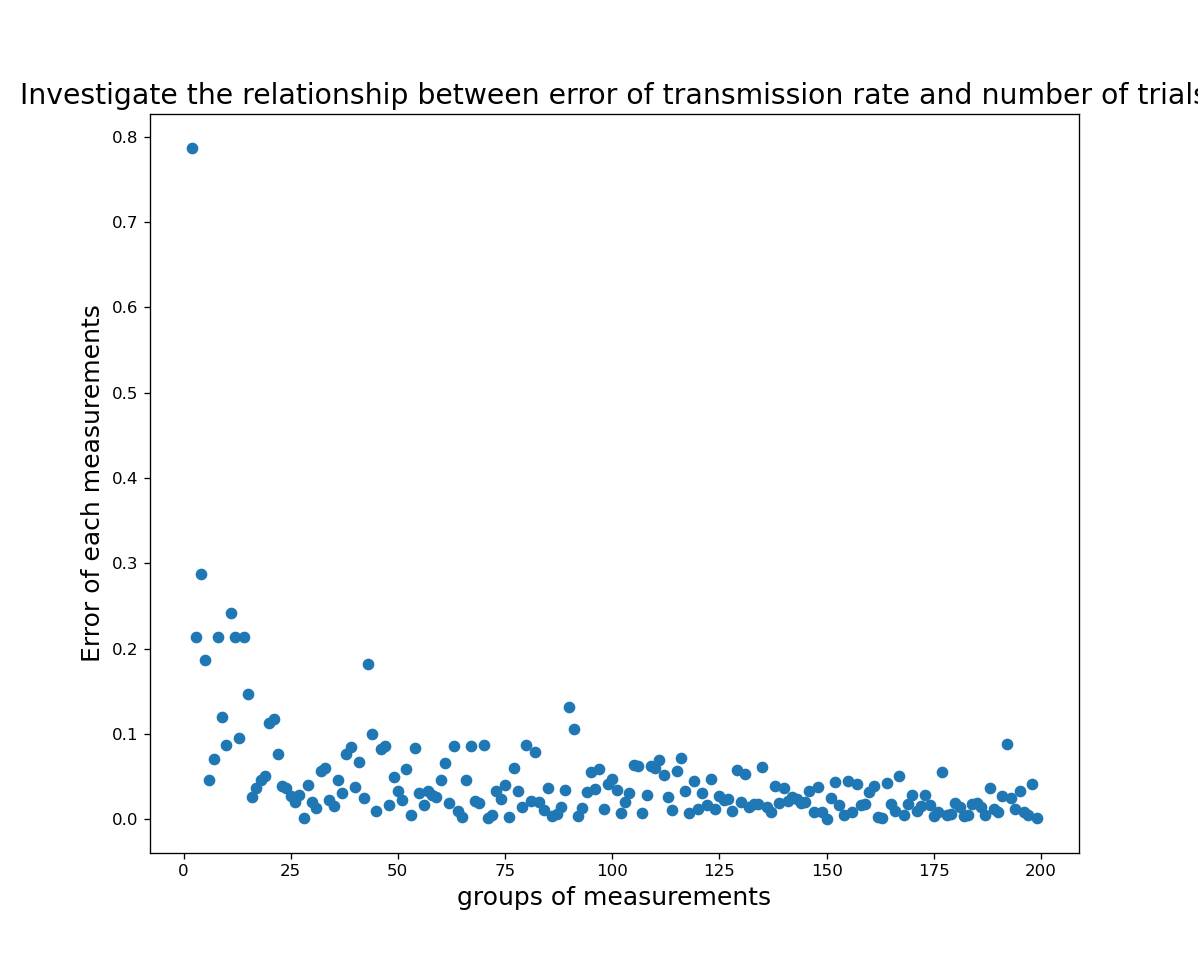

<IPython.core.display.Javascript object>

In [251]:
x_array = np.arange(2, 200, 1)  # number of trials
mean_reflection_water = np.array(
    mean_reflection_water
)  # The mean reflection neutron with different trials
fluctuation = abs(mean_reflection_water[:, 0] - np.mean(mean_reflection_water[:, 0]))
mean_reflection_whole_sample = np.sum(mean_reflection_water[:, 0] * x_array) / np.sum(
    x_array
)  # weighted the mean

percentage_error_binomial = (
    np.sqrt(x_array * mean_reflection_whole_sample * (1 - mean_reflection_whole_sample))
    / x_array
)  # I calculated the percentage
# error in here.
percentage_error_normal = np.sqrt(x_array * mean_reflection_whole_sample) / x_array

######
"plot"
######
PLOT_NAME = "Investigate the relationship between error of transmission rate and number of trials"
X_LABEL = "groups of measurements"
Y_LEBEL = "Error of each measurements"
fig = plt.figure(figsize=(10, 8))
main_plot = fig.add_subplot(111)
main_plot.set_title(PLOT_NAME, fontsize="17")
main_plot.set_xlabel(X_LABEL, fontsize="15")
main_plot.set_ylabel(Y_LEBEL, fontsize="15")
main_plot.scatter(x_array, fluctuation)
plt.show()

data_array = reshaper([x_array, mean_reflection_water[:, 0]])
######
"plot"
######
error = np.std(data_array[:, 1])
PLOT_NAME = "investigate the fluctuation of the transmission rate"
X_LABEL = "number of trials"
Y_LEBEL = "Mean percentage of transmission"
fig = plt.figure(figsize=(10, 8))
main_plot = fig.add_subplot(111)
main_plot.set_title(PLOT_NAME, fontsize="17")
main_plot.set_xlabel(X_LABEL, fontsize="15")
main_plot.set_ylabel(Y_LEBEL, fontsize="15")
main_plot.plot(data_array[:, 0], data_array[:, 1])

# fluctuation region binomial
main_plot.plot(
    data_array[:, 0],
    percentage_error_binomial + mean_reflection_whole_sample,
    "k--",
    color="b",
)
main_plot.plot(
    data_array[:, 0],
    -percentage_error_binomial + mean_reflection_whole_sample,
    "k--",
    color="b",
    label="fluctuation region binomial 68% confidence region",
)
# fluctuation region normal
main_plot.plot(
    data_array[:, 0], percentage_error_normal + mean_reflection_whole_sample, "k--"
)
main_plot.plot(
    data_array[:, 0],
    -percentage_error_normal + mean_reflection_whole_sample,
    "k--",
    label="fluctuation region normal",
)
main_plot.legend()
plt.show()



As we can see here, the standard deviation of normal distribution overestimates the fluctuation of the transmission rate. The width of binomial distribution covers almost all the fluctuation. Few transmission rates surpass the width of the binomial distribution. to cover the 95% sample point, we need time the standard deviation by 1.645:$$CI_{95\%} = \mu ± 1.645\sigma_{binomial}$$

Another reason for the fluctuation exceeding the 68% confidence interval is that we have three bins though one of the bins has nearly zero probability says the transmission. However, binomial distribution only describes two outcomes. This brings the extra deviation and pushes the error to exceed the error boundary of the binomial distribution.

In [252]:
######
"plot"
######
error = np.std(data_array[:, 1])
PLOT_NAME = "investigate the fluctuation of the transmission rate"
X_LABEL = "groups of measurements"
Y_LEBEL = "Mean percentage of transmission"
fig = plt.figure(figsize=(8, 6))
main_plot = fig.add_subplot(111)
main_plot.set_title(PLOT_NAME, fontsize="17")
main_plot.set_xlabel(X_LABEL, fontsize="15")
main_plot.set_ylabel(Y_LEBEL, fontsize="15")
main_plot.plot(data_array[:, 0], data_array[:, 1])

# fluctuation region binomial
main_plot.plot(
    data_array[:, 0],
    1.645 * percentage_error_binomial + mean_reflection_whole_sample,
    "k--",
    color="b",
)
main_plot.plot(
    data_array[:, 0],
    -1.645 * percentage_error_binomial + mean_reflection_whole_sample,
    "k--",
    color="b",
    label="95% confidence region binomial",
)
# fluctuation region normal
main_plot.plot(
    data_array[:, 0], percentage_error_normal + mean_reflection_whole_sample, "k--"
)
main_plot.plot(
    data_array[:, 0],
    -percentage_error_normal + mean_reflection_whole_sample,
    "k--",
    label="fluctuation region normal",
)
main_plot.legend()
plt.show()


<IPython.core.display.Javascript object>

It works pretty well! 95% confidence region of binomial distribution indeed covers almost all the fluctuation of the percentage of reflection of the neutron in water slab.

However, if we calculate $$np ≥ 5$$ and $$n(1 – p) ≥ 5$$, we find that the distribution or transmission of the neutron can be treated as a normal distribution when trials(n) greater than 25. We can see this from the above figures. To show this more clearly, we make a histogram with the x-axis representing the mean of the transmission.

In [253]:
mean_reflection_water_3_trials = []
# make 1000 groups of measurements
for i in range(1000):
    # 3 trials
    (
        neutron_transmission,
        neutron_reflection,
        neutron_absorption,
        neutron_summary,
    ) = tally_error(random_path, 3, water, 10, number_of_neutron_per_trial=1)
    mean_reflection_water_3_trials.append(neutron_reflection)


In [254]:
mean_reflection_water_50_trials = []
# make 100 groups of measurements
for i in range(100):
    # 50 trials per group
    (
        neutron_transmission,
        neutron_reflection,
        neutron_absorption,
        neutron_summary,
    ) = tally_error(random_path, 50, water, 10, number_of_neutron_per_trial=1)
    mean_reflection_water_50_trials.append(neutron_reflection)


<IPython.core.display.Javascript object>


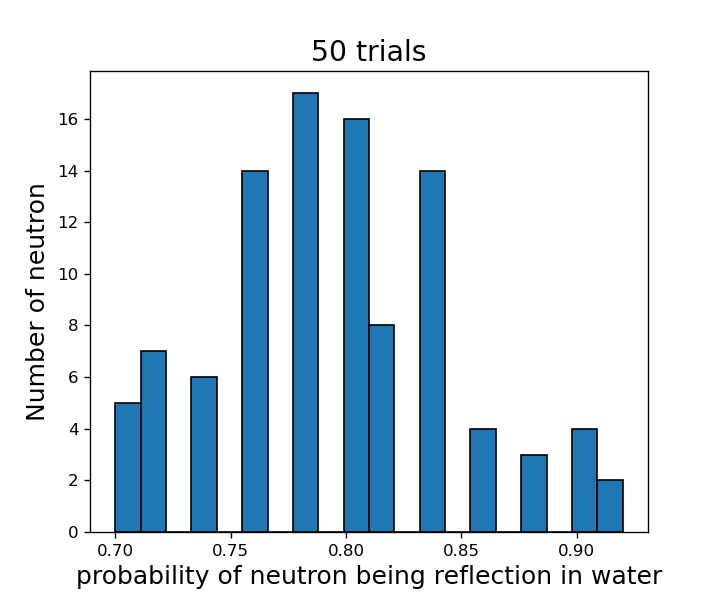

<IPython.core.display.Javascript object>


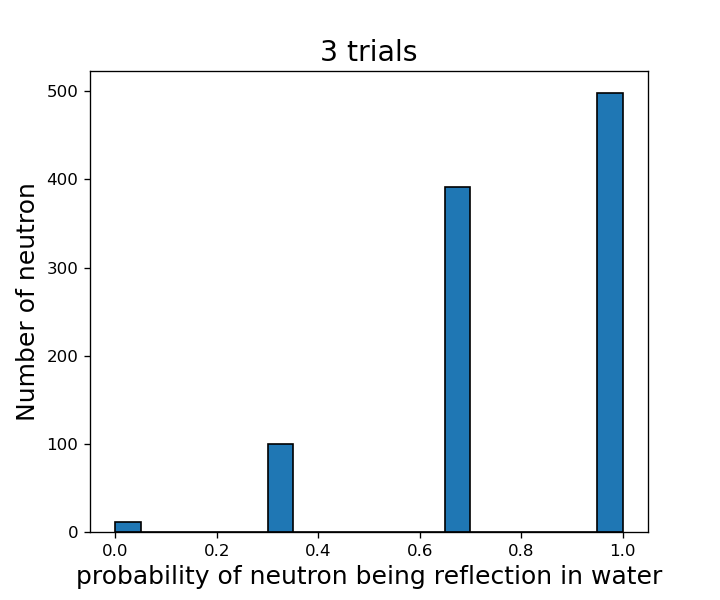

In [255]:
mean_reflection_water_3_trials = np.array(mean_reflection_water_3_trials)
mean_reflection_water_50_trials = np.array(mean_reflection_water_50_trials)
##########
'plot'
##########
X_LABEL = 'probability of neutron being reflection in water'
Y_LABEL = 'Number of neutron'
hist_plot(mean_reflection_water_50_trials[:,0], '50 trials', 20, X_LABEL, Y_LABEL)
hist_plot(mean_reflection_water_3_trials[:,0], '3 trials', 20, X_LABEL, Y_LABEL)

We can see the histogram of 3 trials follows a binomial distribution but the 30 trials histogram shows a normally distributed shape! We need to do more groups of measurements to get a more normally distributed shape.

We simulate 1000 or more neutrons each time so that we can conclude the standard deviation of the three outcomes follows a binomial distribution with a 68% confidence interval.

In [256]:
#simulate neutron in different material
start = time.time()
print("start process")
get_history_water = improved_random_path(water, 10, 10000)
get_history_lead = improved_random_path(lead, 10, 10000)
get_history_graphite = improved_random_path(graphite, 10, 10000)
end = time.time()
print("time cost", end - start, "s")


start process
time cost 6.906133413314819 s


In [257]:
#get path of neutron in different material
start = time.time()
print("start process")
get_history_water_path = random_path(water, 10, 300)
get_history_lead_path = random_path(lead, 10, 300)
get_history_graphite_path = random_path(graphite, 10, 300)
end = time.time()
print("time cost", end - start, "s")


start process
time cost 1.4354941844940186 s


<IPython.core.display.Javascript object>


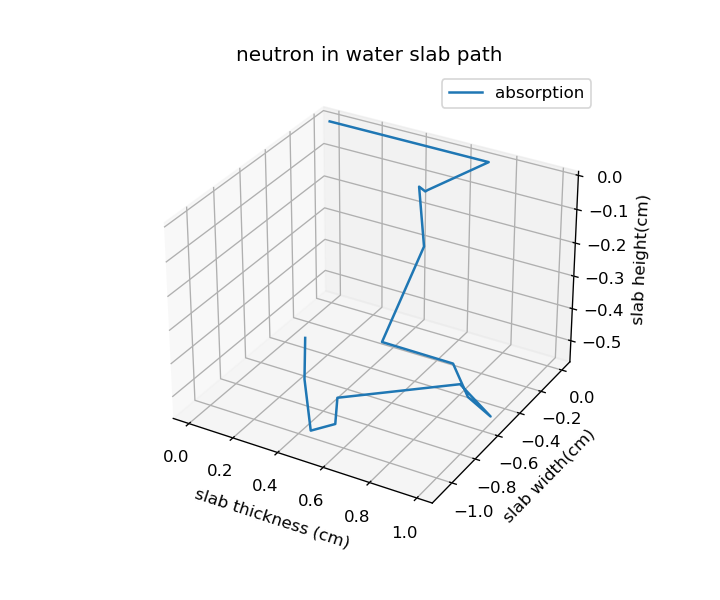

In [258]:
absorptoin_path_water = search_certain_path(get_history_water_path, 'absorption', 100)
######
'plot'
######
PLOT_NAME = 'neutron in water slab path'
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = 'slab height(cm)'
LEGNED = ['absorption']
plot_3D_path(
    absorptoin_path_water,
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGNED
)

In [259]:
create_table(read_history(get_history_water)[0][1], 'neutron in water slab')

transmission reflection absorption
neutron in water slab                                   
0                         0.3±0.1%  79.1±0.4%  20.6±0.4%

<IPython.core.display.Javascript object>


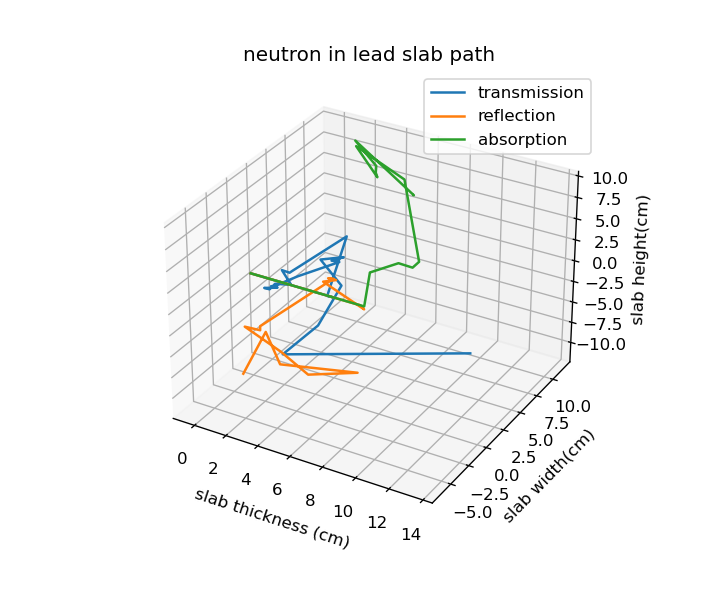

In [260]:
transmission_path_lead = search_certain_path(get_history_lead_path, 'transmission', 300)
absorption_path_lead = search_certain_path(get_history_lead_path, 'absorption', 300)
reflection_path_lead = search_certain_path(get_history_lead_path, 'reflection', 300)
######
'plot'
######
PLOT_NAME = 'neutron in lead slab path'
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = 'slab height(cm)'
LEGENDS = ['transmission', 'reflection', 'absorption']
plot_3D_path(
    [transmission_path_lead,reflection_path_lead,absorption_path_lead],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath = True
)

In [261]:
create_table(read_history(get_history_lead)[0][1], 'neutron in lead slab')

transmission reflection absorption
neutron in lead slab                                   
0                       26.8±0.4%  62.3±0.5%  10.9±0.3%

In [262]:
transmission_path_graphite = search_certain_path(get_history_graphite_path, 'transmission', 300)
absorption_path_graphite = search_certain_path(get_history_graphite_path, 'absorption', 300)
reflection_path_graphite = search_certain_path(get_history_graphite_path, 'reflection', 300)
######
'plot'
######
PLOT_NAME = 'neutron in graphite slab path'
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = 'slab height(cm)'
LEGENDS = ['transmission', 'reflection', 'absorption']
plot_3D_path(
    [transmission_path_graphite,reflection_path_graphite,absorption_path_graphite],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath = True
)

<IPython.core.display.Javascript object>

In [263]:
create_table(read_history(get_history_graphite)[0][1], 'neutron in graphite slab')

transmission reflection absorption
neutron in graphite slab                                   
0                           30.4±0.5%  68.8±0.5%   0.8±0.1%

We can use the number of transmitted neutron to look for the characteristic attenuation length of neutron in different material just like what we did before.

In [264]:
def characteristic_attenuation_length(
    material, method, number_of_neutron_per_trial=1000
):
    transmission_with_different_thinkness = []
    thickness_of_slab = np.linspace(1, 10, 10)
    for i in thickness_of_slab:
        transmission_with_different_thinkness.append(
            tally_error(method, 10, material, i, number_of_neutron_per_trial)[0]
        )
    ######################
    "process data"
    ######################
    transmission_with_different_thinkness_array = np.array(
        transmission_with_different_thinkness
    )
    
    transmission_rate = (
        transmission_with_different_thinkness_array[:, 0] / number_of_neutron_per_trial
    )
    log_transmission_with_different_thinkness_array = np.log(transmission_rate)
    #convert error to log error
    transmission_rate_error = (
        transmission_with_different_thinkness_array[:, 1] / number_of_neutron_per_trial
    )
    log_error_transmission_with_different_thinkness_array = (
        transmission_with_different_thinkness_array[:, 1]
        / transmission_with_different_thinkness_array[:, 0]
    )
    #prepare fitting data
    fitting_data = reshaper(
        [
            thickness_of_slab,
            log_transmission_with_different_thinkness_array,
            log_error_transmission_with_different_thinkness_array,
        ]
    )
    ##############
    "curve fit"
    ##############
    fitting_data = data_filter(fitting_data)
    parameter, parameter_uncertainty = fitting_curve(fitting_data, 1)
    characteristic_attenuation_length = -1 / parameter[0]

    return (
        fitting_data,
        characteristic_attenuation_length,
        (parameter, parameter_uncertainty),
        (transmission_rate, transmission_rate_error),
    )


In [265]:
print("start process")
(
    fitted_data_water,
    characteristic_attenuation_length_water,
    parameter_information_water,
    transmission_rate_water,
) = characteristic_attenuation_length(water, improved_random_path, 1000)
print("neutron in water complete")
(
    fitted_data_lead,
    characteristic_attenuation_length_lead,
    parameter_information_lead,
    transmission_rate_lead,
) = characteristic_attenuation_length(lead, improved_random_path, 1000)
print("neutron in lead complete")
(
    fitted_data_graphite,
    characteristic_attenuation_length_graphite,
    parameter_information_graphite,
    transmission_rate_graphite,
) = characteristic_attenuation_length(graphite, improved_random_path, 1000)
print("neutron in graphite complete")


start process
neutron in water complete
neutron in lead complete
neutron in graphite complete


In [266]:
# dictionary of keeping results
collect_characteristic_attenuation = {
    "neutron attenuation length in water": "{0:.2f}± {1:.2f} cm".format(
        characteristic_attenuation_length_water,
        abs(
            characteristic_attenuation_length_water
            * parameter_information_water[1][0][0] ** 0.5
            / parameter_information_water[0][0]
        ),
    ),
    "neutron attenuation length in lead": "{0:.1f}± {1:.1f}cm".format(
        characteristic_attenuation_length_lead,
        abs(
            characteristic_attenuation_length_lead
            * parameter_information_lead[1][0][0] ** 0.5
            / parameter_information_lead[0][0]
        ),
    ),
    "neutron attenuation length in graphite": "{0:.1f}± {1:.1f}cm".format(
        characteristic_attenuation_length_graphite,
        abs(
            characteristic_attenuation_length_graphite
            * parameter_information_graphite[1][0][0] ** 0.5
            / parameter_information_graphite[0][0]
        ),
    ),
}
# dictionary used for presenting the data plotted on the graph as a table
# We need this because we don't want our data point distributed with bias.
# It also just similar to what I did during the experiment-collecting data in the excel table and read excel
# file to fit the curve.
table_end_of_neutron_in_water = {
    "transmission_rate": transmission_rate_water[0],
    "transmission_error": transmission_rate_water[1],
}
table_end_of_neutron_in_lead = {
    "transmission_rate": transmission_rate_lead[0],
    "transmission_error": transmission_rate_lead[1],
}
table_end_of_neutron_in_graphite = {
    "transmission_rate": transmission_rate_graphite[0],
    "transmission_error": transmission_rate_graphite[1],
}

In [267]:
create_table(table_end_of_neutron_in_water,'Neutron transmission rate in water slab')

transmission_rate  transmission_error
Neutron transmission rate in water slab                                       
0                                                   0.3169            0.010681
1                                                   0.1573            0.006754
2                                                   0.0899            0.007355
3                                                   0.0559            0.008166
4                                                   0.0306            0.003583
5                                                   0.0194            0.004565
6                                                   0.0128            0.003842
7                                                   0.0083            0.001616
8                                                   0.0042            0.001833
9                                                   0.0019            0.001375

In [268]:
create_table(table_end_of_neutron_in_lead,'Neutron transmission rate in lead slab')

transmission_rate  transmission_error
Neutron transmission rate in lead slab                                       
0                                                  0.7525            0.012266
1                                                  0.6657            0.017123
2                                                  0.5783            0.014806
3                                                  0.5306            0.017124
4                                                  0.4604            0.021560
5                                                  0.4144            0.017397
6                                                  0.3659            0.015385
7                                                  0.3354            0.017089
8                                                  0.3009            0.007880
9                                                  0.2754            0.006785

In [269]:
create_table(table_end_of_neutron_in_graphite,'Neutron transmission rate in graphite slab')

transmission_rate  \
Neutron transmission rate in graphite slab                      
0                                                      0.7608   
1                                                      0.6596   
2                                                      0.5943   
3                                                      0.5225   
4                                                      0.4780   
5                                                      0.4284   
6                                                      0.3880   
7                                                      0.3636   
8                                                      0.3311   
9                                                      0.3014   

                                            transmission_error  
Neutron transmission rate in graphite slab                      
0                                                     0.007400  
1                                                     0.011901  
2                                                     0.009456  
3                                                     0.016132  
4                                                     0.013304  
5                                                     0.011901  
6                                                     0.011100  
7                                                     0.016842  
8                                                     0.014335  
9                                                     0.015233

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>


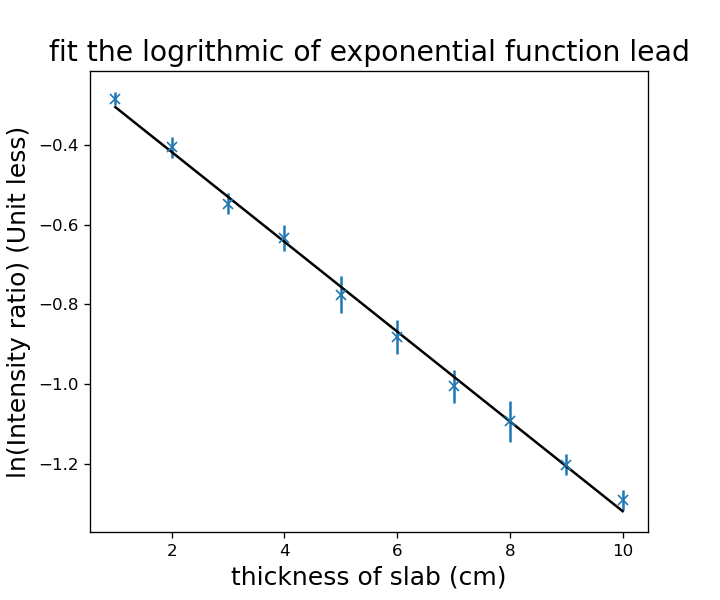

<IPython.core.display.Javascript object>

In [270]:
###############
"plot water slab"
###############
X_LABEL = "thickness of slab (cm)"
Y_LABEL = "ln(Intensity ratio) (Unit less)"
TITLE = "fit the logrithmic of exponential function water"
plot_curve_fit(
    fitted_data_water,
    linear_function,
    parameter_information_water[0],
    X_LABEL,
    Y_LABEL,
    TITLE,
)

###############
"plot lead slab"
###############
X_LABEL = "thickness of slab (cm)"
Y_LABEL = "ln(Intensity ratio) (Unit less)"
TITLE = "fit the logrithmic of exponential function lead"
plot_curve_fit(
    fitted_data_lead,
    linear_function,
    parameter_information_lead[0],
    X_LABEL,
    Y_LABEL,
    TITLE,
)

####################
"plot graphite slab"
####################
X_LABEL = "thickness of slab (cm)"
Y_LABEL = "ln(Intensity ratio) (Unit less)"
TITLE = "fit the logrithmic of exponential function graphite"
plot_curve_fit(
    fitted_data_graphite,
    linear_function,
    parameter_information_graphite[0],
    X_LABEL,
    Y_LABEL,
    TITLE,
)


The neutron attenuation length in different material is summarized in the table below.

In [271]:
create_table(collect_characteristic_attenuation, 'Neutron attenuation length in different material')

neutron attenuation length in water  \
Neutron attenuation length in different material                                       
0                                                                      1.87± 0.05 cm   

                                                 neutron attenuation length in lead  \
Neutron attenuation length in different material                                      
0                                                                        8.9± 0.2cm   

                                                 neutron attenuation length in graphite  
Neutron attenuation length in different material                                         
0                                                                            9.9± 0.3cm

<font face="Time New Roman" size=5 color=black >
4. Woodcock method

If we instead have one material shield but have a multi-material shield, the condition statement should be set more carefully. 
When the neutron has a random path that crosses the boundary of two materials, we need to calculate the macroscopic cross-section separately in different materials to avoid statistical error and bias. However, the particle might move back and forth between two materials. If we keep tracing the path, calculating the absorption rate separately, and doing the condition statement with the old method, it would have a high time cost which leads us to the Woodcock method.

The mechanism behind the Woodcock method is to set the fictitious movement. Instead of letting the path of the particle follow an exponential distribution, we take the fictitious movement in the slab that has a LOWER macroscopic cross-section.$$\Sigma_{T} = argmax(\Sigma_{1}, \Sigma_{2})$$. The condition for having a fictitious movement is that the uniform distributed random number from 0 to 1 is greater than the fictitious movement threshold which is: $$\frac{\Sigma_{current}}{\Sigma_{max}}$$ 

If the particle in the material has a max cross-section, we can see that the particle only takes the real movement and has no chance to be greater than this threshold.
This is the smart point of the Woodcock method. By inspecting the fictitious movement threshold, we save the time for calculating the geometry of the neutron when crossing the material boundary and also the time for the condition statement because the particle in fictitious movement is assumed never absorbed and scattered! The particle just maintains moving in the old direction.

In [272]:
# create a new method that can calculate the mean free path
def collect_mean_free_path(material, thickness_of_slab):
    index = len(thickness_of_slab)
    if not index == len(material):
        sys.exit()
    #calculate absorptiona and scatter cross section
    get_absorption = []
    get_scattering = []

    for index, value in enumerate(material):
        get_absorption.append(1 / calculate_mean_free_path(material[index])[0])
        get_scattering.append(calculate_mean_free_path(material[index])[1])
        
    get_absorption = np.array(get_absorption)
    get_scattering = np.array(get_scattering)
    
    #calculate cross section and mean free path for each material
    cross_section_array = get_absorption + get_scattering
    mean_free_path_array = 1 / cross_section_array
    #calculate absorption probability and scatter probability
    probability_absorption = get_absorption / (get_absorption + get_scattering)
    probability_scattering = get_scattering / (get_absorption + get_scattering)

    return (
        probability_absorption,
        probability_scattering,
        cross_section_array,
        mean_free_path_array,
    )


In [273]:
# trace the particle's position.
def find_region(position, region):
    if position > region[-1]:
        return -2  # if particle transimitted, we return -2
    elif position < region[0]:
        return -1  # if particle reflectd, we return -1
    else:
        temp = np.where(region > position)[0]
        nth_region = np.amin(temp)
        return nth_region  # if particle is still in the slab, we return the current position of the neutron.


def vector_calculator(x_y_z_array):
    (
        x,
        y,
        z,
    ) = x_y_z_array  # calculate the direction of the neutron for the fictitious movement.
    radius = np.sqrt(x ** 2 + y ** 2 + z ** 2)
    return np.array([x / radius, y / radius, z / radius])


def region_list(thickness_of_slab):
    region = [0]  # left boundary is setted at 0cm.
    for i, value in enumerate(thickness_of_slab):
        region.append(
            region[i] + value
        )  # add the material boundary. If water slab is 10cm, then [0,10]
    region = np.array(region)
    return region


In [274]:

def woodcock_method(
    material, thickness_of_slab, number_of_neutron
):  # thickness_of_slab
    # and material need to be a list with same length
    (
        get_probability_absorption,
        get_probability_scattering,
        get_cross_section_array,
        get_mean_free_path_array,
    ) = collect_mean_free_path(material, thickness_of_slab)

    max_cross_section = np.amax(get_cross_section_array)
    min_mean_free_path = np.amin(get_mean_free_path_array)

    region = region_list(thickness_of_slab)
    # keep history of all neutrons
    history = {
        "history": [],
        "transmission": 0,
        "transmission_error": 0,
        "reflection": 0,
        "reflection_error": 0,
        "absorption": 0,
        "absorption_error": 0,
    }

    for count in range(number_of_neutron):
        # dictionary traces a neutron
        path = {
            "numer_of_path": 0,
            "track_each_path": np.zeros((0, 3)),
            "track_path": np.zeros((0, 3)),
            "transmission": 0,
            "reflection": 0,
            "absorption": 0,
        }

        neutron_initial_position = np.array(
            [exponential(0, 1, 1, min_mean_free_path)[0][0], 0, 0]
        )  # first movement, positive x
        position_index = find_region(
            neutron_initial_position[0], region
        )  # position of the neutron

        if (
            position_index > 0
        ):  # if the neutron in the slab, step into loop recall nature number means the material where neutron at.
            path["numer_of_path"] += 1
            path["track_each_path"] = np.vstack(
                (path["track_each_path"], neutron_initial_position)
            )  # track the path of this neutron since it enter the slab
            path[
                "track_path"
            ] = neutron_initial_position  # track the last step of the neutron

            # the x axis displacement of the neutron. This axis is parallel with thickness of the slab
            
            #########################
            "decision"
            #########################

            while region[0] < path["track_path"][0] < region[-1]:

                threshold = np.random.uniform(0, 1)  # calcualte threshold
                current_cross_section = get_cross_section_array[
                    position_index - 1
                ]  # update the macroscopic cross section
                
                fictitious_probability = (
                    current_cross_section / max_cross_section
                )  # calculate the fictitious movement threshold
                
                position_index = find_region(path["track_path"][0], region)
                
                #################
                'fictitious step'
                #################
                if threshold > fictitious_probability:  # if threshold greater than the fictitious probability
                                                        # Take fictitious movement

                    displacement_direction = vector_calculator(
                        path["track_each_path"][-1]
                    )  # update the direction of movement.
                    random_path, _ = exponential(0, 1, 1, min_mean_free_path)
                    fictitious_movement = random_path * displacement_direction
                    path["track_each_path"] = np.vstack(
                        (
                            path["track_each_path"],
                            path["track_each_path"][-1] + fictitious_movement,
                        )
                    )#add the path to history path
                    path["track_path"] = path["track_path"] + fictitious_movement # update the last path
                
            ###################################
            #real step
                else: 
                    random_path, random_number = generate_spherical_distribution(
                        0, 1, 1, get_mean_free_path_array[position_index - 1]
                    )
                    # The random_path has [[]] type so we need to this line to reduce its dimension.
                    random_path = random_path[0]
                    
                    # in the real step region
                    if random_number < get_probability_absorption[position_index - 1]:
                        history["absorption"] += 1  
                        path["absorption"] += 1
                        break
                    else:
                        path["numer_of_path"] += 1
                        path["track_each_path"] = np.vstack(
                            (
                                path["track_each_path"],
                                path["track_each_path"][-1] + np.array(random_path),
                            )
                        )

                        last_path = path["track_path"]
                        path["track_path"] = last_path + np.array(random_path)
                position_index = find_region(
                    path["track_path"][0], region
                )  # update the position
                # leave the slab region
                if position_index == -2:
                    path["transmission"] += 1
                    history["transmission"] += 1
                    break
                elif position_index == -1:
                    path["reflection"] += 1
                    history["reflection"] += 1
                    break
                # still in the slab region, we update the neutron position
                # continue iteration untill the neutron left the region
            history["transmission_error"] = np.sqrt(
                history["transmission"] * (1 - history["transmission"] / number_of_neutron)
            )
            history["reflection_error"] = np.sqrt(
                history["reflection"] * (1 - history["reflection"] / number_of_neutron)
            )
            history["absorption_error"] = np.sqrt(
                history["absorption"] * (1 - history["absorption"] / number_of_neutron)
            )
        history["history"].append(path)
    return history


To check if the woodcock method works, we simply set two layers as water with different thickness

In [275]:
get_history_water_water = woodcock_method([water,water], [5,5], 1000)

In [276]:
create_table(read_history(get_history_water_water)[0][1],'test woodcock method')

transmission reflection absorption
test woodcock method                                   
0                        0.2±0.1%  80.8±1.2%  19.0±1.2%

The neutron transmission rate, reflection rate, and absorption rate in the water water double layer slab is the same as we only has one layer of water slab which suggest Woodcook method does work! We could also setting a vacuum layer by adding a new dictionary to contain its information.

In [277]:
get_history_graphite_water = woodcock_method([graphite, water], [10,10], 1000)
get_history_graphite_lead = woodcock_method([graphite, lead], [10,10], 1000)
get_history_lead_water = woodcock_method([lead, water], [10,10], 1000)
get_history_graphite_lead_water = woodcock_method([graphite,lead, water], [10,10, 10],1000)

In [278]:
create_table(read_history(get_history_graphite_water)[0][1],'neutron in graphite water double layer')

transmission reflection absorption
neutron in graphite water double layer                                   
0                                          0.9±0.3%  35.4±1.5%  63.7±1.5%

In [279]:
create_table(read_history(get_history_lead_water)[0][1],'neutron in lead water double layer')

transmission reflection absorption
neutron in lead water double layer                                   
0                                      1.2±0.3%  31.5±1.5%  67.3±1.5%

In [280]:
create_table(read_history(get_history_graphite_lead)[0][1],'neutron in graphite lead double layer')

transmission reflection absorption
neutron in graphite lead double layer                                   
0                                        14.4±1.1%  77.4±1.3%   8.2±0.9%

In [281]:
create_table(read_history(get_history_graphite_lead_water)[0][1],'neutron in graphite lead water triple layer')

transmission reflection absorption
neutron in graphite lead water triple layer                                   
0                                               1.0±0.3%  33.5±1.5%  65.5±1.5%

<IPython.core.display.Javascript object>


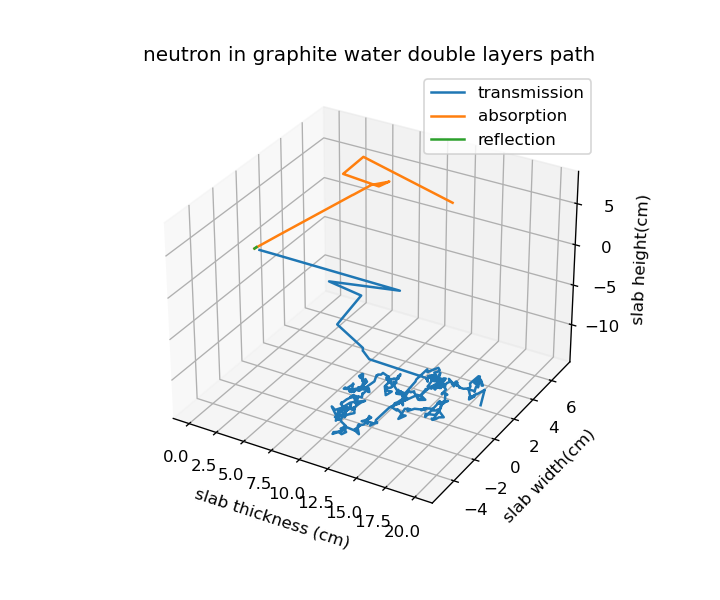

In [282]:
transmission_path_graphite_water = search_certain_path(
    get_history_graphite_water, "transmission", 1000
)
absorption_path_graphite_water = search_certain_path(
    get_history_graphite_water, "absorption", 1000
)
reflection_path_graphtie_water = search_certain_path(
    get_history_graphite_water, "reflection", 1000
)
######
"plot"
######
PLOT_NAME = "neutron in graphite water double layers path"
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = "slab height(cm)"
LEGENDS = ["transmission", "absorption", "reflection"]
plot_3D_path(
    [
        transmission_path_graphite_water,
        absorption_path_graphite_water,
        reflection_path_graphtie_water,
    ],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath=True,
)


In [ ]:
transmission_path_lead_water = search_certain_path(
    get_history_lead_water, "transmission", 1000
)
absorption_path_lead_water = search_certain_path(
    get_history_lead_water, "absorption", 1000
)
reflection_path_lead_water = search_certain_path(
    get_history_lead_water, "reflection", 1000
)
######
"plot"
######
PLOT_NAME = "neutron in lead water double layers path"
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = "slab height(cm)"
LEGENDS = ["transmission", "absorption", "reflection"]
plot_3D_path(
    [
        transmission_path_lead_water,
        absorption_path_lead_water,
        reflection_path_lead_water,
    ],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath=True,
)


In [ ]:
transmission_path_graphite_lead = search_certain_path(
    get_history_graphite_lead, "transmission", 1000
)
absorption_path_graphite_lead = search_certain_path(
    get_history_graphite_lead, "absorption", 1000
)
reflection_path_graphite_lead = search_certain_path(
    get_history_graphite_lead, "reflection", 1000
)
######
"plot"
######
PLOT_NAME = "neutron in graphite lead double layers path"
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = "slab height(cm)"
LEGENDS = ["transmission", "absorption", "reflection"]
plot_3D_path(
    [
        transmission_path_graphite_lead,
        absorption_path_graphite_lead,
        reflection_path_graphite_lead,
    ],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath=True,
)

In [ ]:

transmission_path_graphite_lead_water = search_certain_path(
    get_history_graphite_lead_water, "transmission", 1000
)
absorption_path_graphite_lead_water = search_certain_path(
    get_history_graphite_lead_water, "absorption", 1000
)
reflection_path_graphtie_lead_water = search_certain_path(
    get_history_graphite_lead_water, "reflection", 1000
)
######
"plot"
######
PLOT_NAME = "neutron in graphite lead water triple layers path"
X_LABEL = "slab thickness (cm)"
Y_LABEL = "slab width(cm)"
Z_LABEL = "slab height(cm)"
LEGENDS = ["transmission", "absorption", "reflection"]
plot_3D_path(
    [
        transmission_path_graphite_lead_water,
        absorption_path_graphite_lead_water,
        reflection_path_graphtie_lead_water,
    ],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath=True,
)

From the above plot, we can see that neutron is absorbed in either the graphite layer or the lead layer which makes sense because neutron in graphite and lead has a higher absorption rate.

<font face="Time New Roman" size=5 color=black >
5. neutron movement in sphere shape material

We now want to simulate the emitted neutron from a radioactive element that is placed in the tungsten carbide. This material provides a relatively high reflection rate and stability at high temperatures. Most importantly, the neutron should have nearly no transmission rate in this material. This structure is used in America's first nuclear bomb.

Neutron in Tungsten carbide has a high reflection rate but nearly no absorption rate which shortens the decay time of the radioactive element and accelerates the chain reaction.

In [283]:
def spherical_random_path(
    material, inner_radius_of_slab, outer_radius_of_slab, number_of_neutron
):

    # information
    get_absorption_mean_free_path, get_scattering = calculate_mean_free_path(material)
    get_absorption = 1 / get_absorption_mean_free_path
    total_mean_free_path = 1 / (get_absorption + get_scattering)
    probability_absorption = get_absorption / (get_absorption + get_scattering)
    probability_scattering = get_scattering / (get_absorption + get_scattering)
    # keep history
    history = {
        "history": [],
        "transmission": 0,
        "transmission_error": 0,
        "reflection": 0,
        "reflection_error": 0,
        "absorption": 0,
        "absorption_error": 0,
    }

    ###################################
    "step into loop"
    ###################################
    for count in range(number_of_neutron):
        path = {
            "numer_of_path": 0,
            "track_each_path": np.zeros((0, 3)),
            "track_path": np.array((0, 3)),
            "transmission": 0,
            "reflection": 0,
            "absorption": 0,
        }

        # The entered neutron is perpendicular to the shield.
        initial_radius_direction = generate_isotropic_unit_vector(1)[0]
        initial_position = inner_radius_of_slab * initial_radius_direction
        enter_neutron = (
            initial_radius_direction * exponential(0, 1, 1, total_mean_free_path)[0][0]
        )
        enter_neutron = enter_neutron + initial_position
        radius = (
            enter_neutron[0] ** 2 + enter_neutron[1] ** 2 + enter_neutron[2] ** 2
        ) ** 0.5  # radius of the neutron(x,y,z)
        # 0< because we might get enter neutron equals zero
        if inner_radius_of_slab < radius < outer_radius_of_slab:
            path["numer_of_path"] += 2
            path["track_each_path"] = np.vstack(
                (path["track_each_path"], enter_neutron)
            )
            path["track_path"] = np.array(enter_neutron)

            # the x axis displacement of the neutron. This axis is parallel with thickness of the slab
            #########################
            "decision"
            #########################
            while inner_radius_of_slab < radius < outer_radius_of_slab:
                random_path, random_number = generate_spherical_distribution(
                    0, 1, 1, total_mean_free_path
                )
                random_path = random_path[0]

                if random_number < probability_absorption:  # absorption
                    history["absorption"] += 1
                    path["absorption"] += 1
                    break
                # scattering
                else:
                    path["numer_of_path"] += 1
                    path["track_each_path"] = np.vstack(
                        (
                            path["track_each_path"],
                            path["track_each_path"][-1] + np.array(random_path),
                        )
                    )
                    path["track_path"] = path["track_path"] + np.array(random_path)
                    radius = (
                        path["track_path"][0] ** 2
                        + path["track_path"][1] ** 2
                        + path["track_path"][2] ** 2
                    ) ** 0.5
            if radius > outer_radius_of_slab:  # transmission
                path["transmission"] += 1
                history["transmission"] += 1
            elif -inner_radius_of_slab < radius < inner_radius_of_slab:  # reflection
                path["reflection"] += 1
                history["reflection"] += 1
        else:

            path["transmission"] += 1
            history["transmission"] += 1
        history["history"].append(path)
    # calculate rate of three outcomes.
    history["transmission_error"] = np.sqrt(
        history["transmission"] * (1 - history["transmission"] / number_of_neutron)
    )
    history["reflection_error"] = np.sqrt(
        history["reflection"] * (1 - history["reflection"] / number_of_neutron)
    )
    history["absorption_error"] = np.sqrt(
        history["absorption"] * (1 - history["absorption"] / number_of_neutron)
    )
    return history


To test the spherical random path, we could set the radius of the shield appropriately. It can not be too large because the shape of the shield is reduced to a spherical shell. It can not be too small because of the mean free path of the neutron.

In [284]:
spherical_slab_lead = spherical_random_path(lead, 10, 60, 1000)
create_table(read_history(spherical_slab_lead)[0][1], 'neutron in lead spherical shield')

transmission reflection absorption
neutron in lead spherical shield                                   
0                                    3.9±0.6%  51.2±1.6%  44.9±1.6%

<IPython.core.display.Javascript object>


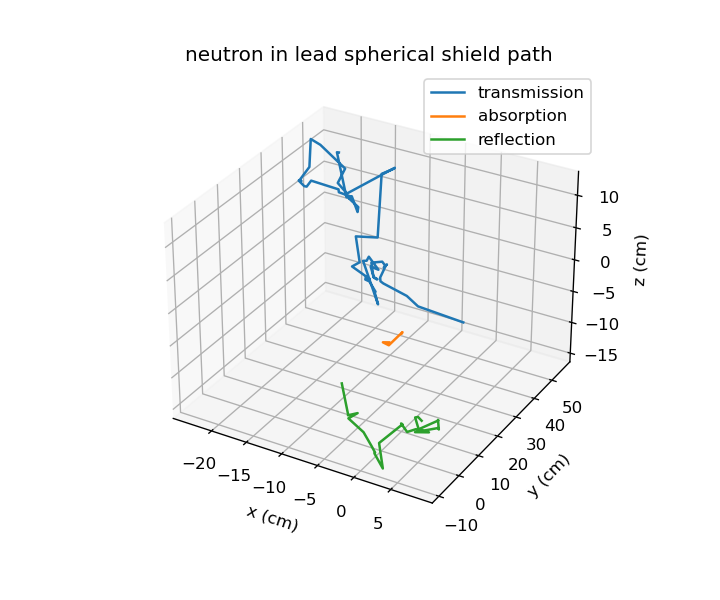

In [285]:
transmission_path_lead = search_certain_path(spherical_slab_lead, "transmission", 1000)
absorption_path_lead = search_certain_path(spherical_slab_lead, "absorption", 1000)
reflection_path_lead = search_certain_path(spherical_slab_lead, "reflection", 1000)
######
"plot"
######
PLOT_NAME = "neutron in lead spherical shield path"
X_LABEL = "x (cm)"
Y_LABEL = "y (cm)"
Z_LABEL = "z (cm)"
LEGENDS = ["transmission", "absorption", "reflection"]
plot_3D_path(
    [transmission_path_lead, absorption_path_lead, reflection_path_lead],
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGENDS,
    multipath=True,
)


The result is excellent!

Now, we simulate the tungsten carbide.

In [293]:
spherical_slab_tungsten_carbide = spherical_random_path(tungsten_carbide, 50, 60, 1000)
create_table(read_history(spherical_slab_tungsten_carbide)[0][1], 'neutron in tungsten carbide slab')

transmission reflection absorption
neutron in tungsten carbide slab                                   
0                                    0.7±0.3%  32.3±1.5%  67.0±1.5%

<IPython.core.display.Javascript object>


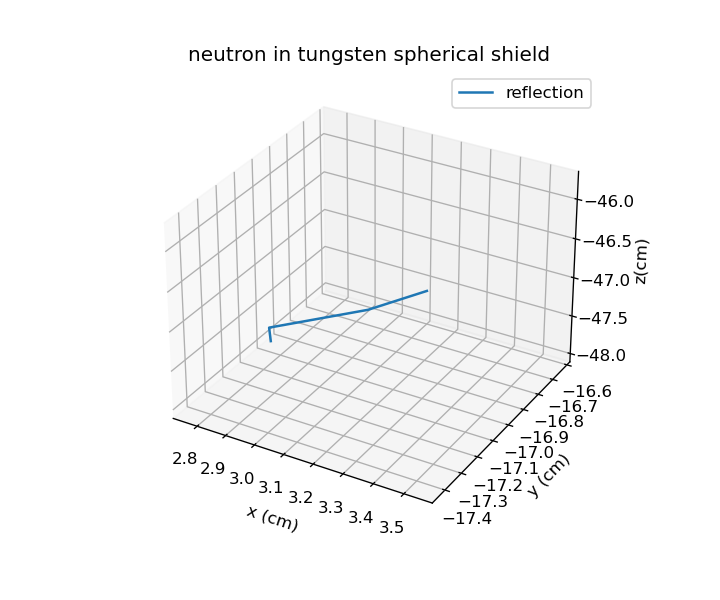

In [294]:
reflection_path_tungsten_carbide = search_certain_path(spherical_slab_tungsten_carbide, 'reflection', 100)
######
'plot'
######
PLOT_NAME = 'neutron in tungsten spherical shield'
X_LABEL = "x (cm)"
Y_LABEL = "y (cm)"
Z_LABEL = 'z(cm)'
LEGNED = ['reflection']
plot_3D_path(
    reflection_path_tungsten_carbide,
    X_LABEL,
    Y_LABEL,
    Z_LABEL,
    PLOT_NAME,
    LEGNED
)

We can improve the running speed for a random walk of the neutron in the spherical shield.

In [295]:
def spherical_random_path_improved(
    material, inner_radius_of_slab, outer_radius_of_slab, number_of_neutron
):
    if inner_radius_of_slab >= outer_radius_of_slab:
        print("inner radius can not larger than outer radius of the slab")
        sys.exit()
    # information
    get_absorption_mean_free_path, get_scattering = calculate_mean_free_path(material)
    get_absorption = 1 / get_absorption_mean_free_path
    total_mean_free_path = 1 / (get_absorption + get_scattering)
    probability_absorption = get_absorption / (get_absorption + get_scattering)
    probability_scattering = get_scattering / (get_absorption + get_scattering)
    # keep history
    history = {
        "history": [],
        "transmission": 0,
        "transmission_error": 0,
        "reflection": 0,
        "reflection_error": 0,
        "absorption": 0,
        "absorption_error": 0,
    }
    ###################################
    "step into loop"
    ###################################
    # The entered neutron is perpendicular to the slab.

    initial_radius_direction = generate_isotropic_unit_vector(number_of_neutron)
    initial_position = inner_radius_of_slab * initial_radius_direction
    random_initial = (
        initial_radius_direction
        * exponential(0, 1, number_of_neutron, total_mean_free_path)[0].reshape(
            number_of_neutron, 1
        )
        + initial_position
    )
    #initial position
    position_neutron = np.zeros((number_of_neutron, 0))
    position_neutron = np.hstack((position_neutron, random_initial))

    while len(position_neutron) > 0:
        random_path, random_number = generate_spherical_distribution(
            0, 1, len(position_neutron), total_mean_free_path
        )
        add_path = reshaper(
            [
                position_neutron[:, -3] + random_path[:, 0],
                position_neutron[:, -2] + random_path[:, 1],
                position_neutron[:, -1] + random_path[:, 2],
            ]
        ) #update path

        position_neutron = np.hstack((position_neutron, add_path))
        radius = (
            position_neutron[:, -3] ** 2
            + position_neutron[:, -2] ** 2
            + position_neutron[:, -1] ** 2
        ) ** 0.5  # radius of the neutron(x,y,z)

        absorped_neutron = np.where(random_number < probability_absorption)

        history["absorption"] += len(absorped_neutron[0])
        position_neutron = np.delete(
            position_neutron, absorped_neutron, 0
        )  # delete absorped neutron
        radius = np.delete(radius, absorped_neutron)

        transmitted_neutron = np.where(radius > outer_radius_of_slab)
        history["transmission"] += len(transmitted_neutron[0])
        position_neutron = np.delete(position_neutron, transmitted_neutron, 0)
        radius = np.delete(radius, transmitted_neutron) #delete trasmitted neutron

        reflected_neutron = np.where(radius < inner_radius_of_slab)
        history["reflection"] += len(reflected_neutron[0])
        position_neutron = np.delete(
            position_neutron, reflected_neutron, 0
        )  # delete reflected neutron
        radius = np.delete(radius, reflected_neutron)
        
    history["transmission_error"] = np.sqrt(
        history["transmission"] * (1 - history["transmission"] / number_of_neutron)
    )
    history["reflection_error"] = np.sqrt(
        history["reflection"] * (1 - history["reflection"] / number_of_neutron)
    )
    history["absorption_error"] = np.sqrt(
        history["absorption"] * (1 - history["absorption"] / number_of_neutron)
    )

    return history


Little boy nuclear bump has diameter 70cm. We assume the outer sphere of the tungsten carbide is 60cm and inner sphere of the tungsten carbide is 50cm. Within this inner sphere, there is a U-235 radioactive source that emitting proton unfailing.

In [296]:
get_history_tungsten_carbide = spherical_random_path_improved(tungsten_carbide, 50,60, 10000)
create_table(read_history(get_history_tungsten_carbide)[0][1], 'neutron in tungsten carbide shield')

transmission reflection absorption
neutron in tungsten carbide shield                                   
0                                      0.8±0.1%  34.7±0.5%  64.5±0.5%

We see that about 35% of the neutron is reflected. 

Welcome to visit my github.
https://github.com/DidyoufinishupLandau

<font face="Time New Roman" size=5 color=black >
Reference

1. Pigni, M., Leal, L., Dunn, M., Guber, K., Trkov, A., Žerovnik, G., Emiliani, F., Kopecky, S., Lampoudis, C., Schillebeeckx, P. and Siegler, P., 2014. Evaluation of Tungsten Neutron Cross Sections in the Resolved Resonance Region. Nuclear Data Sheets, 118, pp.147-150.